DARDAR In Situ v Detrained

In [18]:
#### DARDAR DATA ANALYSIS #######
import numpy as np
import netCDF4 as nc
import xarray as xr
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cartopy.crs as ccrs
from numpy.ma import MaskedArray
#from cdf_funcs import toLocalSolarTime
#import kdtree as kd
#import datetimeim
#import cdf_funcs as cdf
#import pykdtree
#import sklearn.neighbors as sk
#import scipy.spatial as sp
import sys
#import psutil
from copy import deepcopy
import os
import glob
%matplotlib inline

import multiprocessing as mp



from matplotlib.colors import LogNorm

from scipy.ndimage import interpolation as ip

In [19]:
_wbgyr_cdict = {'red': ((0.0,  255./255, 255./255),
                        (0.125, 173./255, 173./255),
                        (0.25,  95./255,  95./255),
                        (0.375, 73./255,  73./255),
                        (0.5,  165./255, 164./255),
                        (0.625, 248./255, 248./255),
                        (0.75, 236./255, 236./255),
                        (0.875, 200./255, 200./255),
                        (1.0,  146./255, 146./255)),
                'green': ((0.0,  255./255, 255./255),
                          (0.125, 224./255, 224./255),
                          (0.25, 163./255, 163./255),
                          (0.375, 166./255, 166./255),
                          (0.5,  207./255, 207./255),
                          (0.625, 184./255, 184./255),
                          (0.75,  86./255,  86./255),
                          (0.875, 29./255,  29./255),
                          (1.0,   21./255,  21./255)),
                'blue': ((0.0,  255./255, 255./255),
                         (0.125, 248./255, 248./255),
                         (0.25, 214./255, 214./255),
                         (0.375, 120./255, 120./255),
                         (0.5,   81./255,  81./255),
                         (0.625, 73./255,  73./255),
                         (0.75,  41./255,  41./255),
                         (0.875, 38./255,  38./255),
                         (1.0,   25./255,  25./255))}
# And reverse
_wbgyr_cdict_r = deepcopy(_wbgyr_cdict)
for i in _wbgyr_cdict_r.keys():
    _wbgyr_cdict_r[i] = [(1-j[0], j[1], j[2]) for j in _wbgyr_cdict_r[i]]
    _wbgyr_cdict_r[i].reverse()

cmap = LinearSegmentedColormap('WBGYR', _wbgyr_cdict)
cmap.set_bad('#D2D2D2')
plt.register_cmap(cmap=cmap)

cmap_r = LinearSegmentedColormap('WBGYR', _wbgyr_cdict_r)
cmap_r.set_bad('#D2D2D2')
plt.register_cmap(cmap=cmap_r)

In [2]:
tsc08 = xr.open_mfdataset('/net/seldon/disk2/Users/gah20/TSCISCCP/TSC_testdelete/2008/TSC_*.nc',combine='nested', concat_dim="time")
#tsc = np.where(tsc08['ConvOrigin']<0,tsc08['TSC'],np.nan)
origin = tsc08['ConvCir']
tsc_lat = tsc08['lat']
tsc_lon = tsc08['lon']
tsc_time = tsc08['time']
tscr = tsc08['TSC']
#tscr = xr.DataArray(tsc, coords=tsc08.coords, dims=tsc08.dims, attrs=tsc08.attrs)

In [46]:
amt_l = np.zeros((501,436))
amtc_l = np.zeros((501,436))

    
amt_o = np.zeros((501,436))
amtc_o = np.zeros((501,436))

ic5_o = np.zeros((501,436))
ic5c_o = np.zeros((501,436))

ic5_l = np.zeros((501,436))
ic5c_l = np.zeros((501,436))

amean = np.zeros((8,501,436))

dar08 = xr.open_mfdataset(name)

dar08 = xr.open_mfdataset('/net/seldon/disk2/Data/DARDAR_Nice/DARNI_L2_PRO.v1.10/2008/2008_01_01/*.nc',combine='nested',concat_dim='time')
basetime = dar08['base_time']
dtime = dar08['dtime']
height = dar08['height']
clm = dar08['clm_v2']
lat = dar08['lat']
lon = dar08['lon']
eff5 = dar08['icnc_5um'][:]
#eff100 = dar08['iwc_error'][:]
mask = clm*dar08['iteration_flag'][:]

cloud_amt = np.where((mask>0)&(mask!=6),1,0)

icnc5 = np.where((mask>0)&(mask!=6),eff5,np.nan)

timediff = (basetime.values - np.datetime64('2008-01-01T00:30:00.00')) / 1e9
diff = (timediff.astype(float) + (dtime.values))
matched_tsctime = (np.round(diff/3600)).astype(int)

latitude = np.round(lat.values).astype(int)
longitude = np.round(lon.values).astype(int)

troplat = np.where((latitude>=-30) & (latitude<=30),latitude,np.nan)
troplon = np.where(np.isnan(troplat),np.nan,longitude)


##########################################################################################################################
indlat = (troplat+32)
indlon = (troplon)

# indices of the latitudes and longitudes of the DARDAR path
indlatn = (indlat[~np.isnan(indlat)]).astype(int)
indlonn = (indlon[~np.isnan(indlon)]).astype(int)

# the tsc at the time of the overpass of the DARDAR path, based on the dtime and basetime
mttn = (matched_tsctime[~np.isnan(indlat)]).astype(int)

i1 = cloud_amt[~np.isnan(indlat),:]
i2 = icnc5[~np.isnan(indlat),:]


indlonn = np.where(indlonn == 360, 0, indlonn)
#indlatn = np.where(indlatn == 64,63,indlatn)

#tscr_o = np.where(origin>10,tscr,np.nan)
#tscr_l = np.where(origin<-10,tscr,np.nan)

tscr_d = np.where(origin>0,tscr,np.nan)
tscr_i = np.where(origin<0,tscr,np.nan)
#print('Hello from the child process')
#try and get the time since convection at the specific location and time of the DARDAR overpass, need to just take the diagonal of the array?
tscdardar_o = (tscr_d[mttn,indlatn,indlonn]).astype(int)
tscdardar_o = (np.where((tscdardar_o<500),tscdardar_o,500)).astype(int)
tscdardar_o = (np.where(tscdardar_o<0,500,tscdardar_o).astype(int))

tscdardar_l = (tscr_i[mttn,indlatn,indlonn]).astype(int)
tscdardar_l = (np.where((tscdardar_l<500),tscdardar_l,500)).astype(int)
tscdardar_l = (np.where(tscdardar_l<0,500,tscdardar_l).astype(int))

np.add.at(amt_l,tscdardar_l,np.where(np.isnan(i1),0,i1))
np.add.at(amtc_l,tscdardar_l,np.where(np.isnan(i1),0,1))

np.add.at(amt_o,tscdardar_o,np.where(np.isnan(i1),0,i1))
np.add.at(amtc_o,tscdardar_o,np.where(np.isnan(i1),0,1))

np.add.at(ic5_o,tscdardar_o,np.where(np.isnan(i2),0,i2))
np.add.at(ic5c_o,tscdardar_o,np.where(np.isnan(i2),0,1))

np.add.at(ic5_l,tscdardar_l,np.where(np.isnan(i2),0,i2))
np.add.at(ic5c_l,tscdardar_l,np.where(np.isnan(i2),0,1))
    
amean[0] = amt_l
amean[1] = amtc_l
amean[2] = amt_o
amean[3] = amtc_o
amean[4] = ic5_o
amean[5] = ic5c_o
amean[6] = ic5_l
amean[7] = ic5c_l

In [37]:
def DARDAR_Analysis(name):
    #print('Hello from the child process')

    amt_l = np.zeros((501,436))
    amtc_l = np.zeros((501,436))
    
        
    amt_o = np.zeros((501,436))
    amtc_o = np.zeros((501,436))
    
    ic5_o = np.zeros((501,436))
    ic5c_o = np.zeros((501,436))
    
    ic5_l = np.zeros((501,436))
    ic5c_l = np.zeros((501,436))

   
    amean = np.zeros((8,501,436))
    
    dar08 = xr.open_mfdataset(name)

    #dar08 = xr.open_mfdataset('/net/seldon/disk2/Data/DARDAR_Nice/DARNI_L2_PRO.v1.10/2008/2008_01_01/*.nc',combine='nested',concat_dim='time')
    basetime = dar08['base_time']
    dtime = dar08['dtime']
    height = dar08['height']
    clm = dar08['clm_v2']
    lat = dar08['lat']
    lon = dar08['lon']
    eff5 = dar08['icnc_5um'][:]
    mask = clm*dar08['iteration_flag'][:]
    
    cloud_amt = np.where((mask>0)&(mask!=6),1,0)
    
    icnc5 = np.where((mask>0)&(mask!=6),eff5,np.nan)

    
    timediff = (basetime.values - np.datetime64('2008-01-01T00:30:00.00')) / 1e9
    diff = (timediff.astype(float) + (dtime.values))
    matched_tsctime = (np.round(diff/3600)).astype(int)
    
    #magnitude = matched_tsctime - (diff/3600)
    #print('magnitude done')
    latitude = np.round(lat.values).astype(int)
    longitude = np.round(lon.values).astype(int)

    troplat = np.where((latitude>=-30) & (latitude<=30),latitude,np.nan)
    troplon = np.where(np.isnan(troplat),np.nan,longitude)
    

    ##########################################################################################################################
    indlat = (troplat+32)
    indlon = (troplon)

    # indices of the latitudes and longitudes of the DARDAR path
    indlatn = (indlat[~np.isnan(indlat)]).astype(int)
    indlonn = (indlon[~np.isnan(indlon)]).astype(int)

    # the tsc at the time of the overpass of the DARDAR path, based on the dtime and basetime
    mttn = (matched_tsctime[~np.isnan(indlat)]).astype(int)
    
    i1 = cloud_amt[~np.isnan(indlat),:]
    i2 = icnc5[~np.isnan(indlat),:]

    
    indlonn = np.where(indlonn == 360, 0, indlonn)
    
    tscr_o = np.where(origin>0,tscr,np.nan)
    tscr_l = np.where(origin<0,tscr,np.nan)
    #print('Hello from the child process')
    #try and get the time since convection at the specific location and time of the DARDAR overpass, need to just take the diagonal of the array?
    tscdardar_o = (tscr_o[mttn,indlatn,indlonn]).astype(int)
    tscdardar_o = (np.where((tscdardar_o<500),tscdardar_o,500)).astype(int)
    tscdardar_o = (np.where(tscdardar_o<0,500,tscdardar_o).astype(int))
    
    tscdardar_l = (tscr_l[mttn,indlatn,indlonn]).astype(int)
    tscdardar_l = (np.where((tscdardar_l<500),tscdardar_l,500)).astype(int)
    tscdardar_l = (np.where(tscdardar_l<0,500,tscdardar_l).astype(int))
    
    np.add.at(amt_l,tscdardar_l,np.where(np.isnan(i1),0,i1))
    np.add.at(amtc_l,tscdardar_l,np.where(np.isnan(i1),0,1))

    np.add.at(amt_o,tscdardar_o,np.where(np.isnan(i1),0,i1))
    np.add.at(amtc_o,tscdardar_o,np.where(np.isnan(i1),0,1))
    
    np.add.at(ic5_o,tscdardar_o,np.where(np.isnan(i2),0,i2))
    np.add.at(ic5c_o,tscdardar_o,np.where(np.isnan(i2),0,1))
    
    np.add.at(ic5_l,tscdardar_l,np.where(np.isnan(i2),0,i2))
    np.add.at(ic5c_l,tscdardar_l,np.where(np.isnan(i2),0,1))
    
    amean[0] = amt_l
    amean[1] = amtc_l
    amean[2] = amt_o
    amean[3] = amtc_o
    amean[4] = ic5_o
    amean[5] = ic5c_o
    amean[6] = ic5_l
    amean[7] = ic5c_l
    
    return amean

In [4]:
filelist = []
for name in glob.glob('/net/seldon/disk2/Data/DARDAR_Nice/DARNI_L2_PRO.v1.10/2008/2008_01_*/*'):
    filelist.append(name)

In [5]:
%%time
with mp.Pool(16) as pool:
    print('doing')
    results1 = pool.map(DARDAR_Analysis, filelist)
    print(pool)

Hello from the child processHello from the child processHello from the child processHello from the child processHello from the child processHello from the child processHello from the child processHello from the child process


Hello from the child process

Hello from the child process

Hello from the child process
Hello from the child processHello from the child processHello from the child process
Hello from the child processHello from the child process






doing
Hello from the child process
Hello from the child process
Hello from the child process
Hello from the child process
Hello from the child process
Hello from the child process
Hello from the child process
Hello from the child process
Hello from the child process
Hello from the child process
Hello from the child process
Hello from the child process
Hello from the child process
Hello from the child process
Hello from the child process
Hello from the child process
Hello from the child process
Hello from the child process
Hello fr

In [6]:
total1 = np.nansum(results1,axis=0)

/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


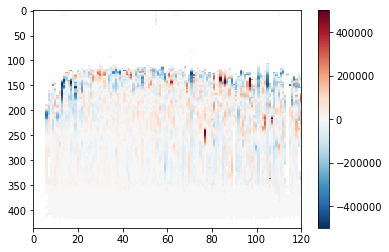

In [49]:
im=plt.imshow((total1[4]/total1[5]).T - (total1[6]/total1[7]).T,cmap='RdBu_r',aspect='auto',vmax=500000,vmin=-500000,interpolation='none')
plt.xlim(0,120)
plt.colorbar(im)

In [50]:
%%time
i = 1
for i in range(1,12,1):
    print(i)
    filelist = []
    for name in glob.glob('/net/seldon/disk2/Data/DARDAR_Nice/DARNI_L2_PRO.v1.10/2008/2008_'+str(i).zfill(2)+'_*/*'):
        filelist.append(name)

    with mp.Pool(16) as pool:
        print('doing')
        results = pool.map(DARDAR_Analysis, filelist)

    #np.save('dardar_'+str(i).zfill(2), results)
    xr.DataArray(results).to_netcdf('DARDARHIST/histogram_IvL_2008'+str(i).zfill(2)+'.nc')

1
doing
2
doing
3
doing
4
doing
5
doing
6
doing
7
doing
8
doing
9
doing
10
doing
11
doing
CPU times: user 32.7 s, sys: 2min 36s, total: 3min 8s
Wall time: 1h 21min 3s


In [63]:
year_icnc = np.zeros((8,501,436))
for i in range(1,12):
    test = nc.Dataset('DARDARHIST/histogram_IvL_2008'+str(i).zfill(2)+'.nc')
    print(test)
    array = test['__xarray_dataarray_variable__']
    month = np.sum(array,axis=0)
    year_icnc = year_icnc + month

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): dim_0(367), dim_1(8), dim_2(501), dim_3(436)
    variables(dimensions): float64 __xarray_dataarray_variable__(dim_0, dim_1, dim_2, dim_3)
    groups: 
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): dim_0(390), dim_1(8), dim_2(501), dim_3(436)
    variables(dimensions): float64 __xarray_dataarray_variable__(dim_0, dim_1, dim_2, dim_3)
    groups: 
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): dim_0(317), dim_1(8), dim_2(501), dim_3(436)
    variables(dimensions): float64 __xarray_dataarray_variable__(dim_0, dim_1, dim_2, dim_3)
    groups: 
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): dim_0(433), dim_1(8), dim_2(501), dim_3(436)
    variables(dimensions): float64 __xarray_dataarray_variable__(d

/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


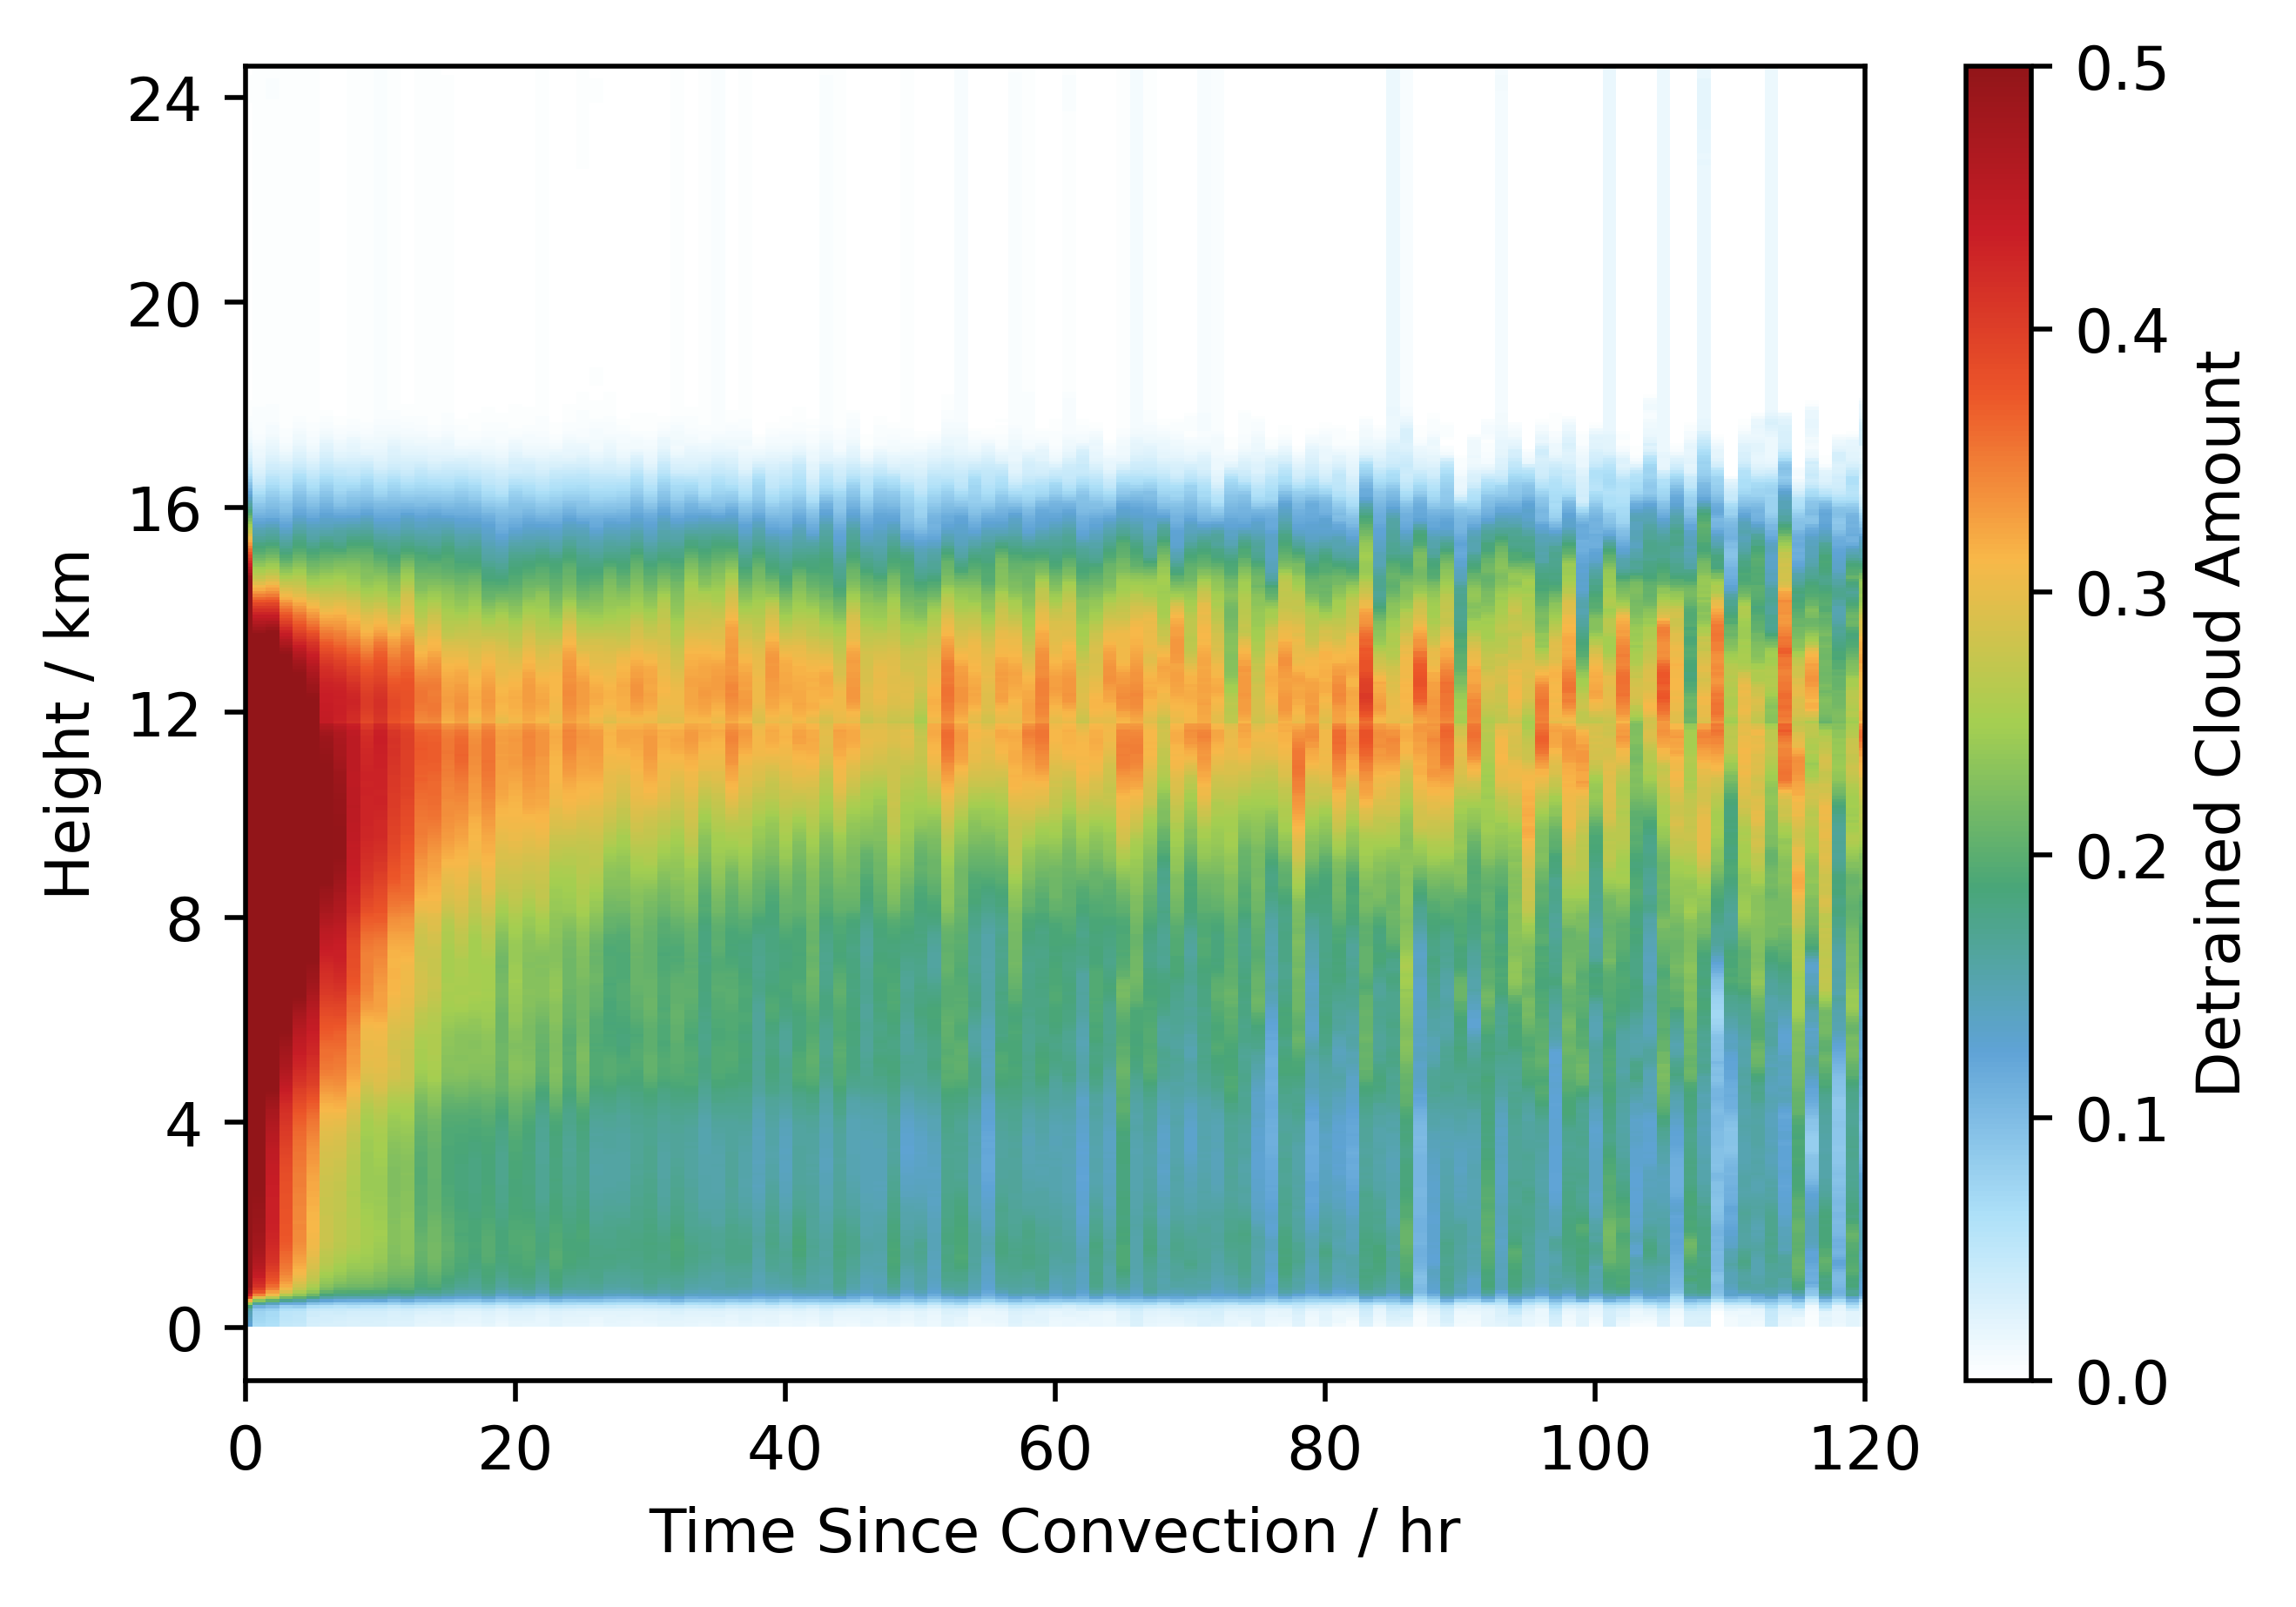

In [111]:
plt.figure(dpi=500)
im=plt.imshow(((year_icnc[2]/year_icnc[3]).T),cmap=cmap,aspect='auto',vmax=0.5,vmin=0)
plt.xlim(0,120)
plt.colorbar(im,label='Detrained Cloud Amount')
plt.yticks(np.arange(418,0,-17*4),labels=(np.arange(0,26,4)))
plt.xlabel('Time Since Convection / hr')
plt.ylabel('Height / km')
plt.savefig('paper2plots/DetvInsitu/DARDAR_CF_D.pdf',bbox_inches='tight',dpi=1200)
plt.show()


/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


(0.0, 120.0)

/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


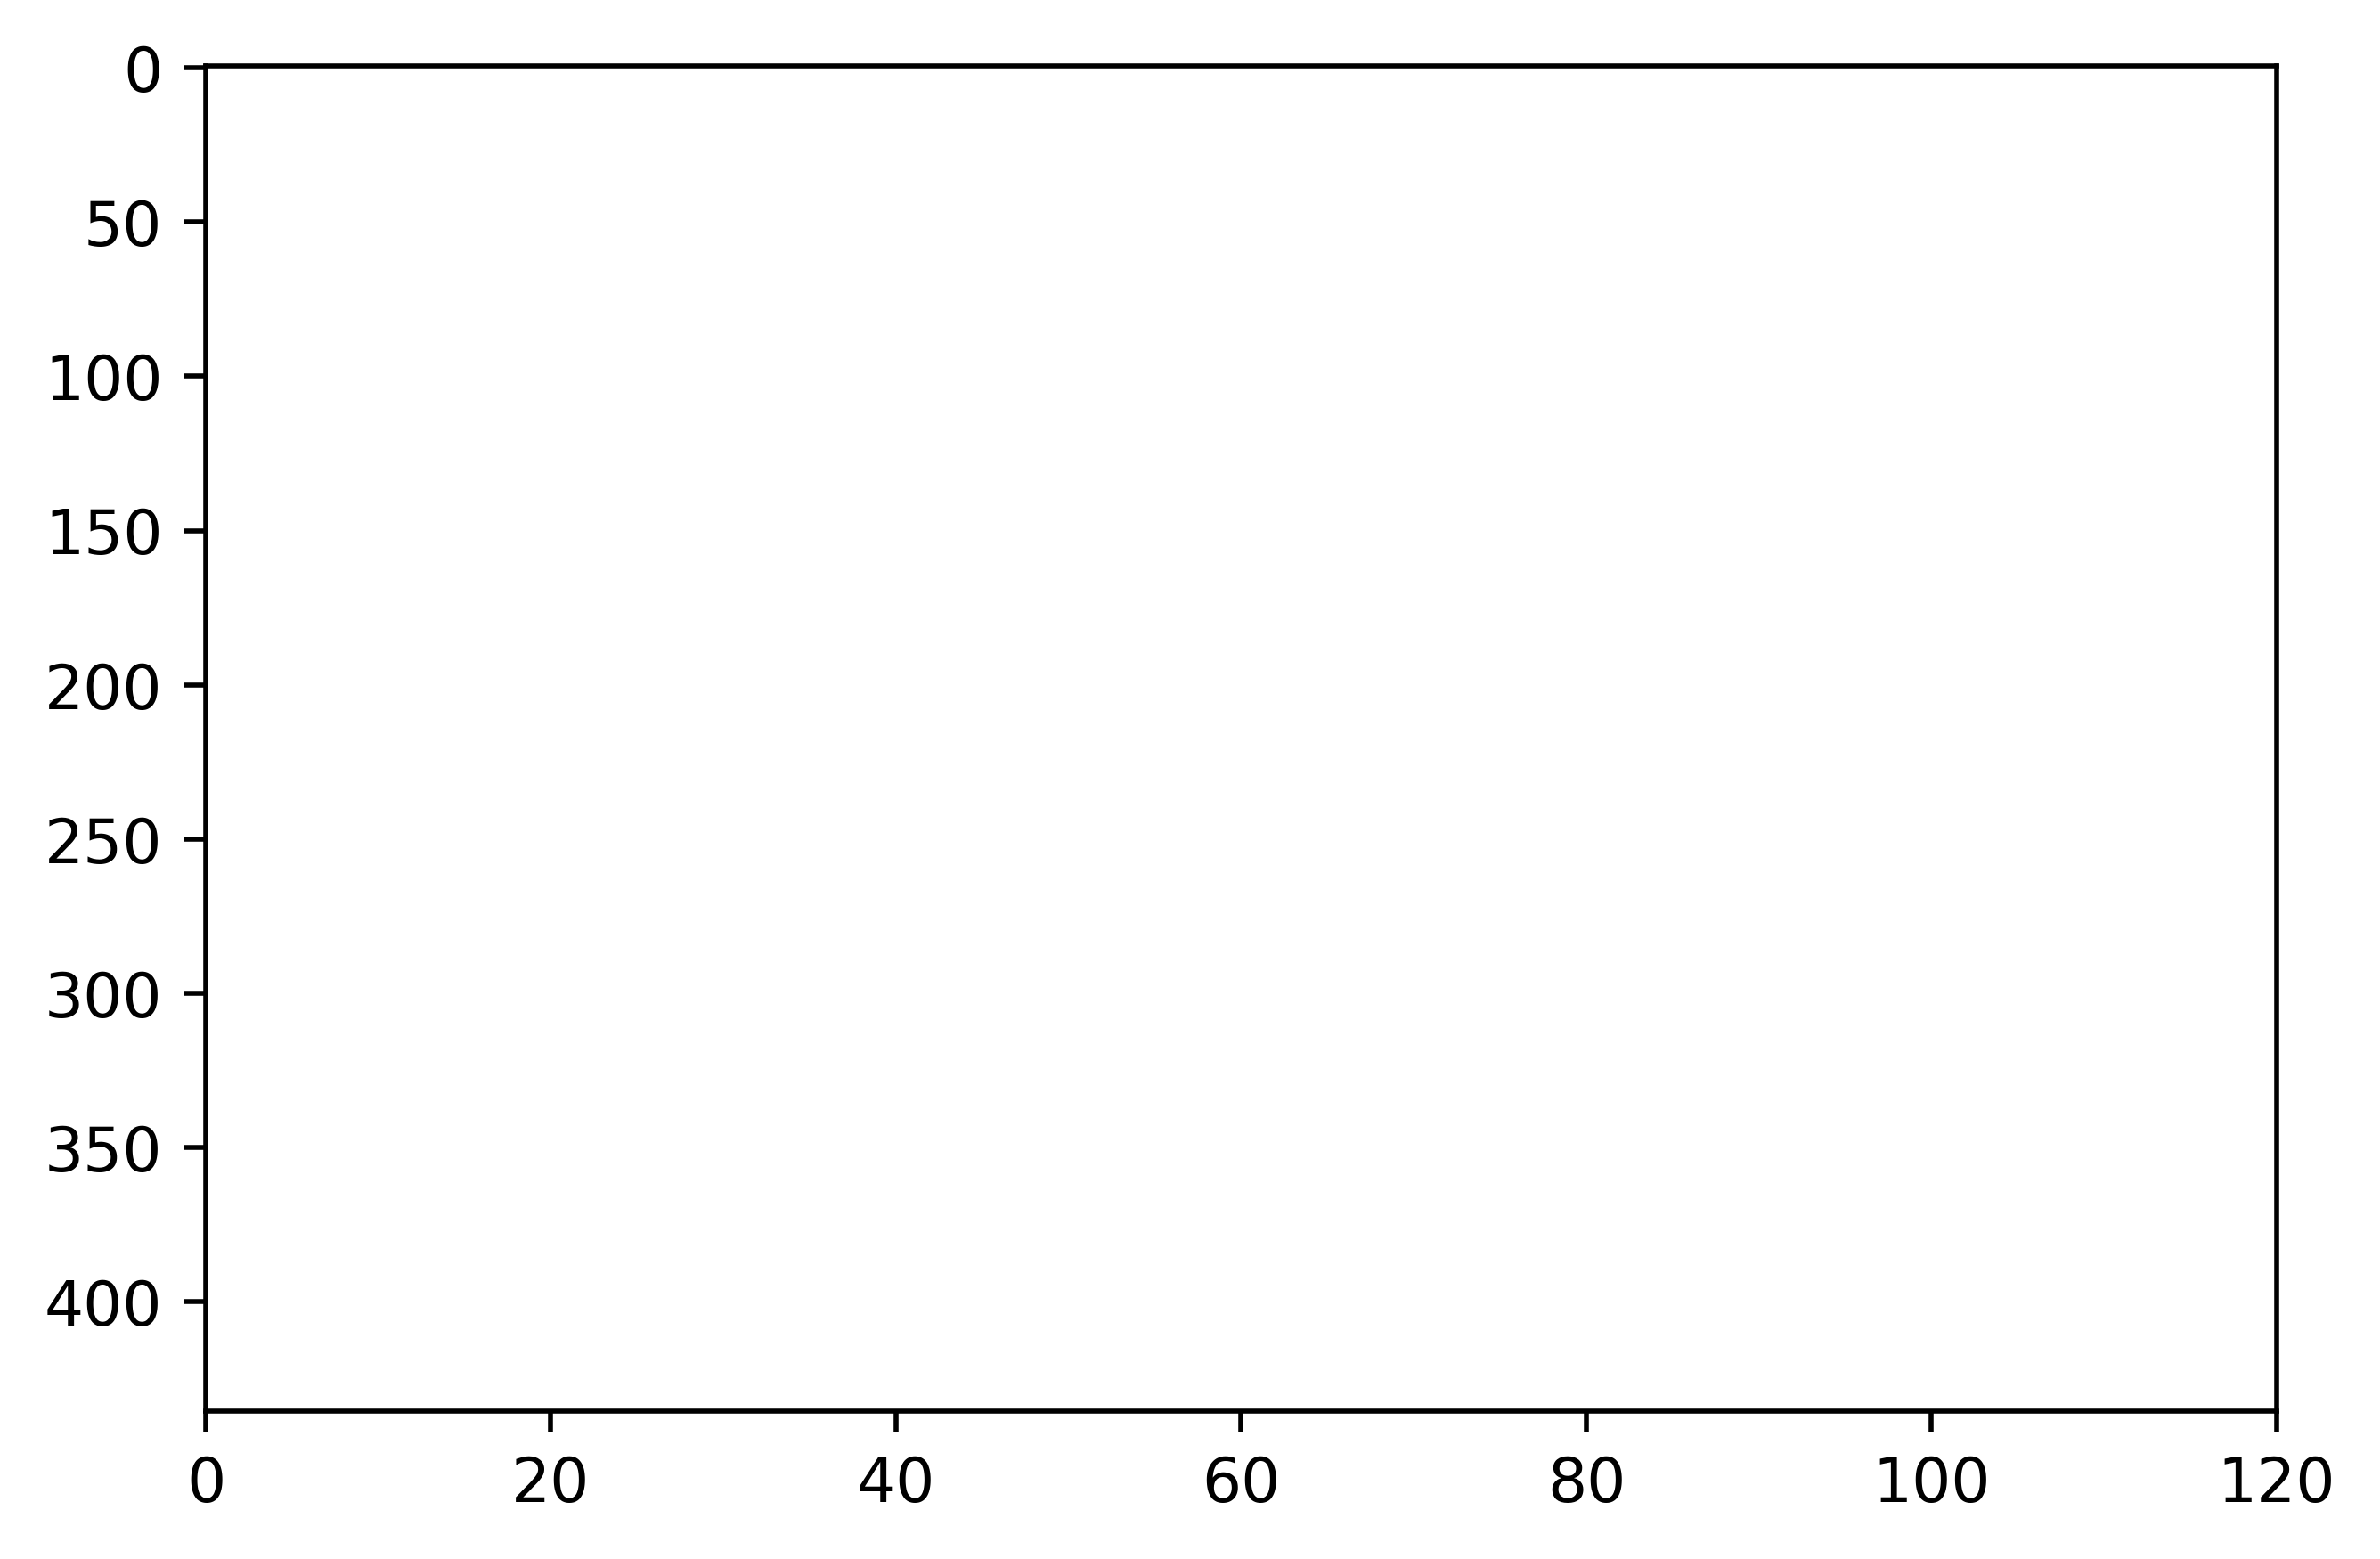

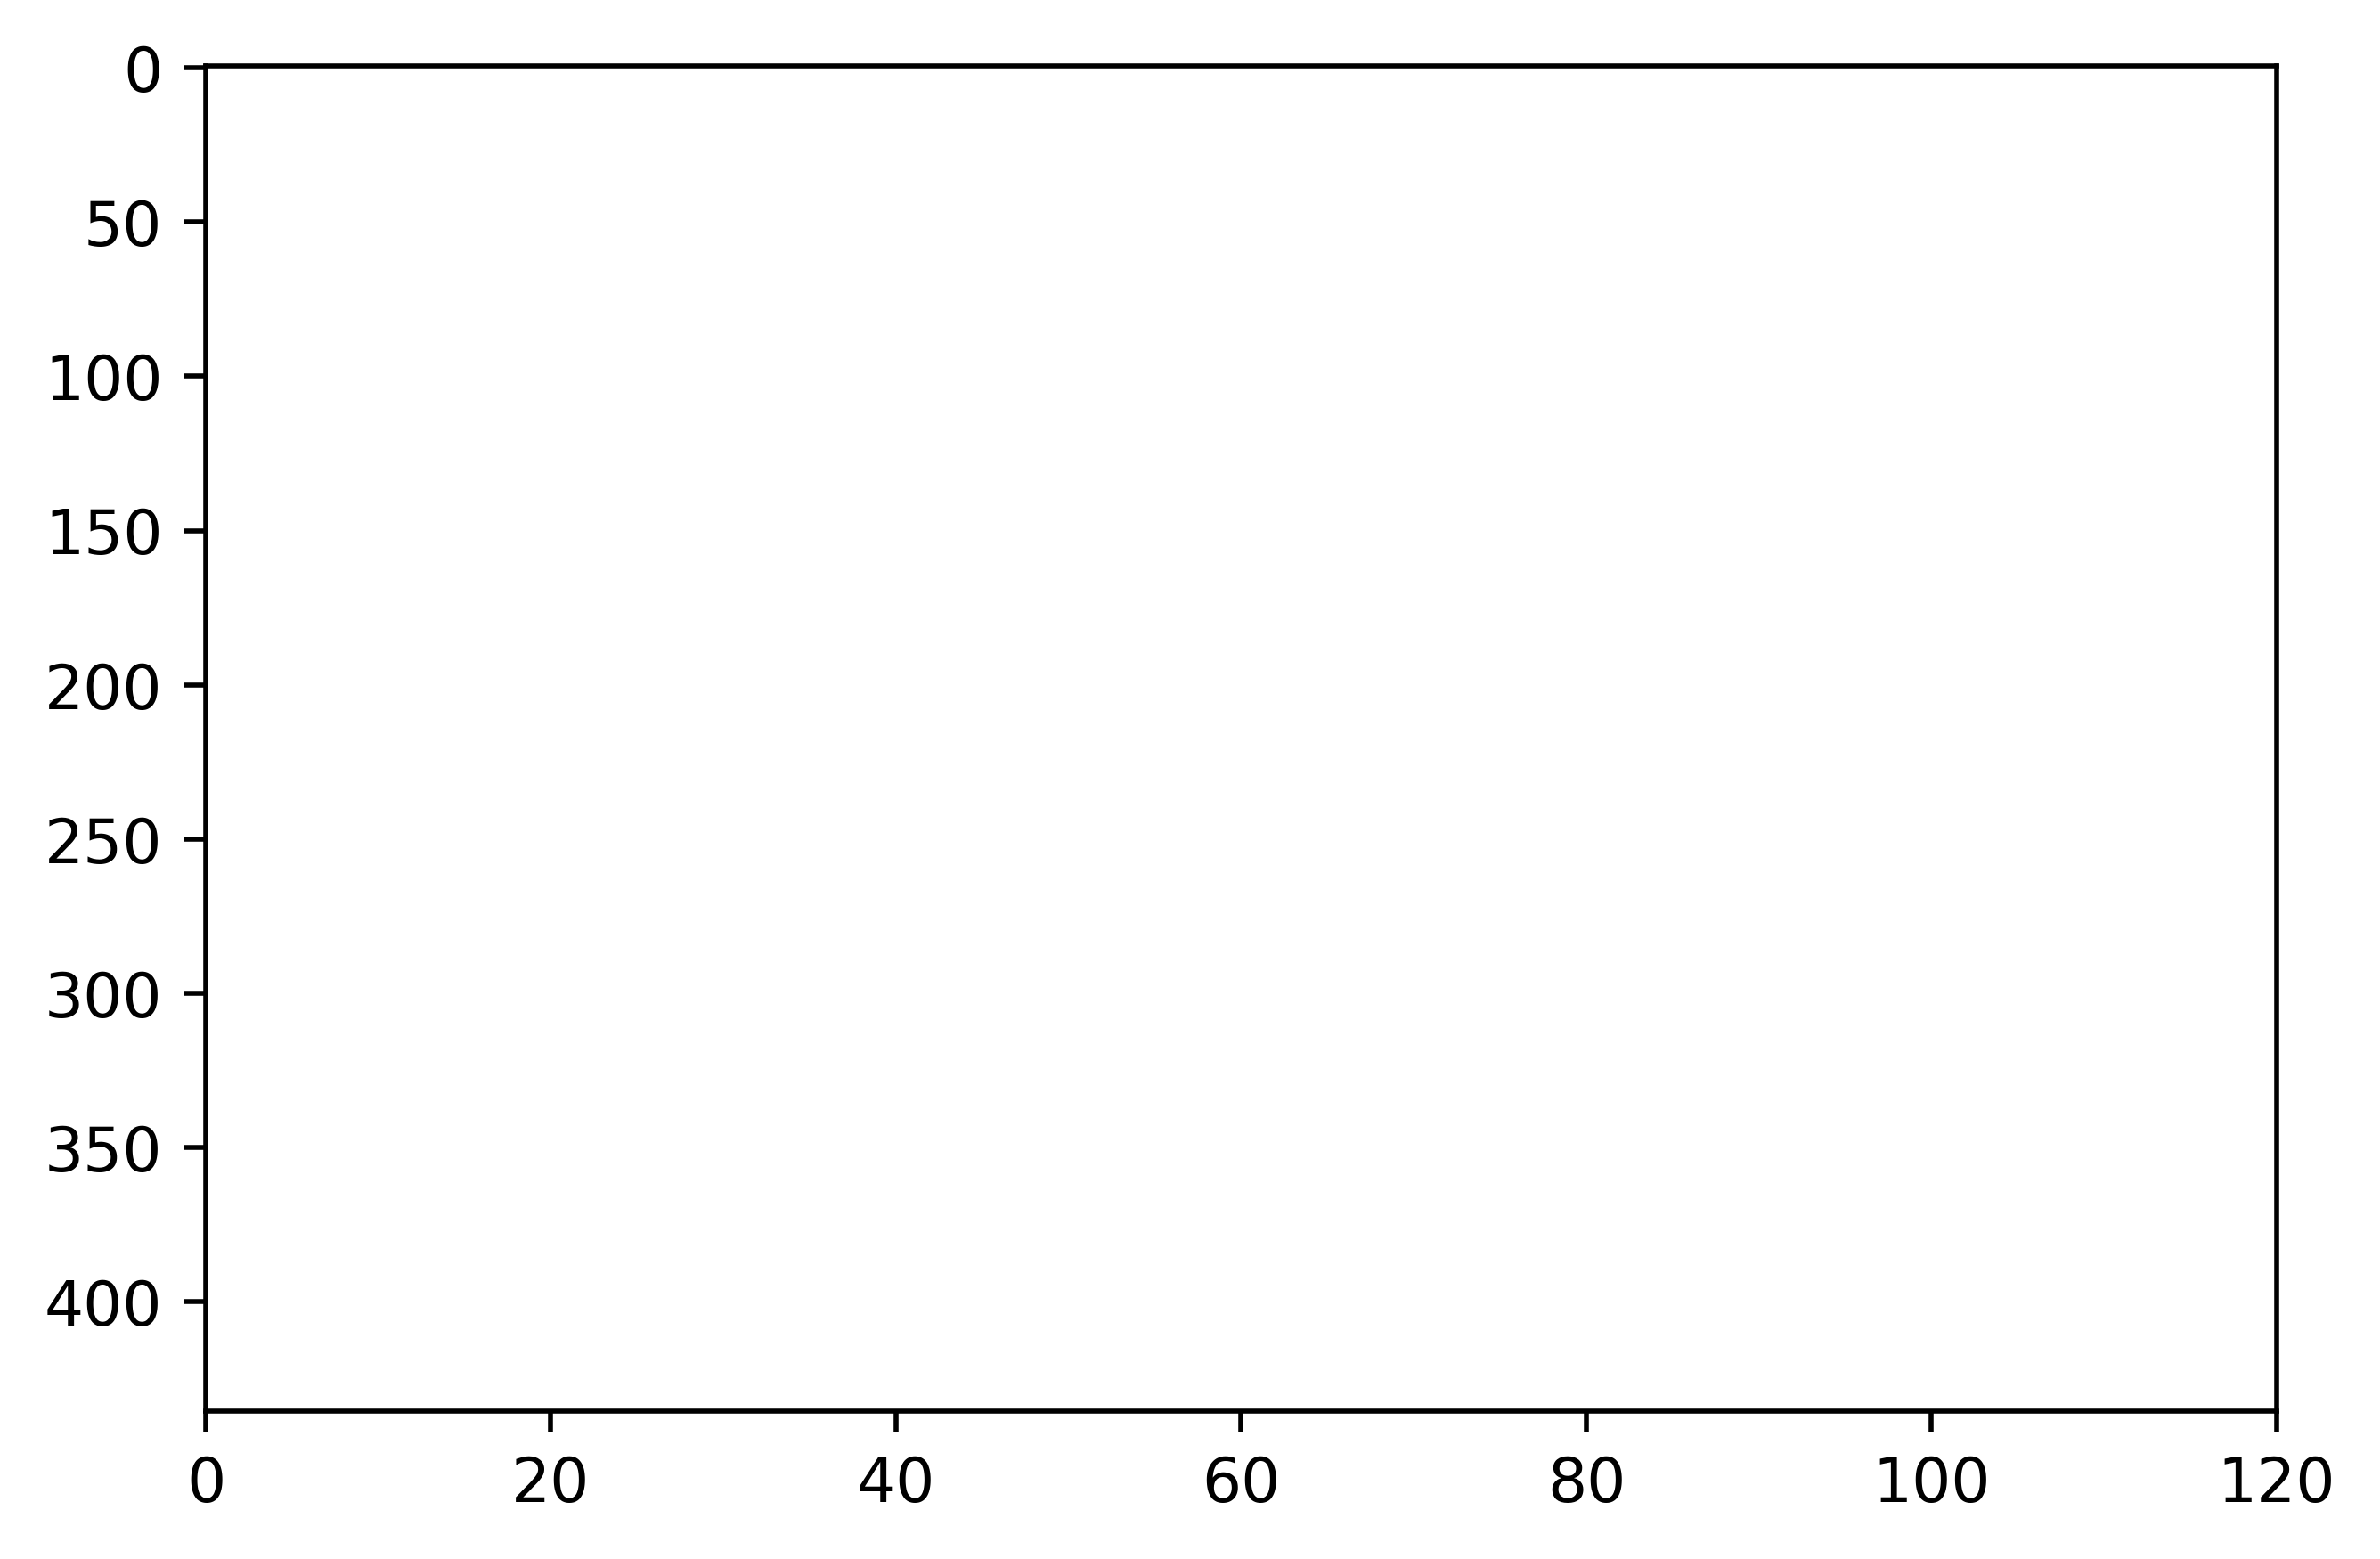

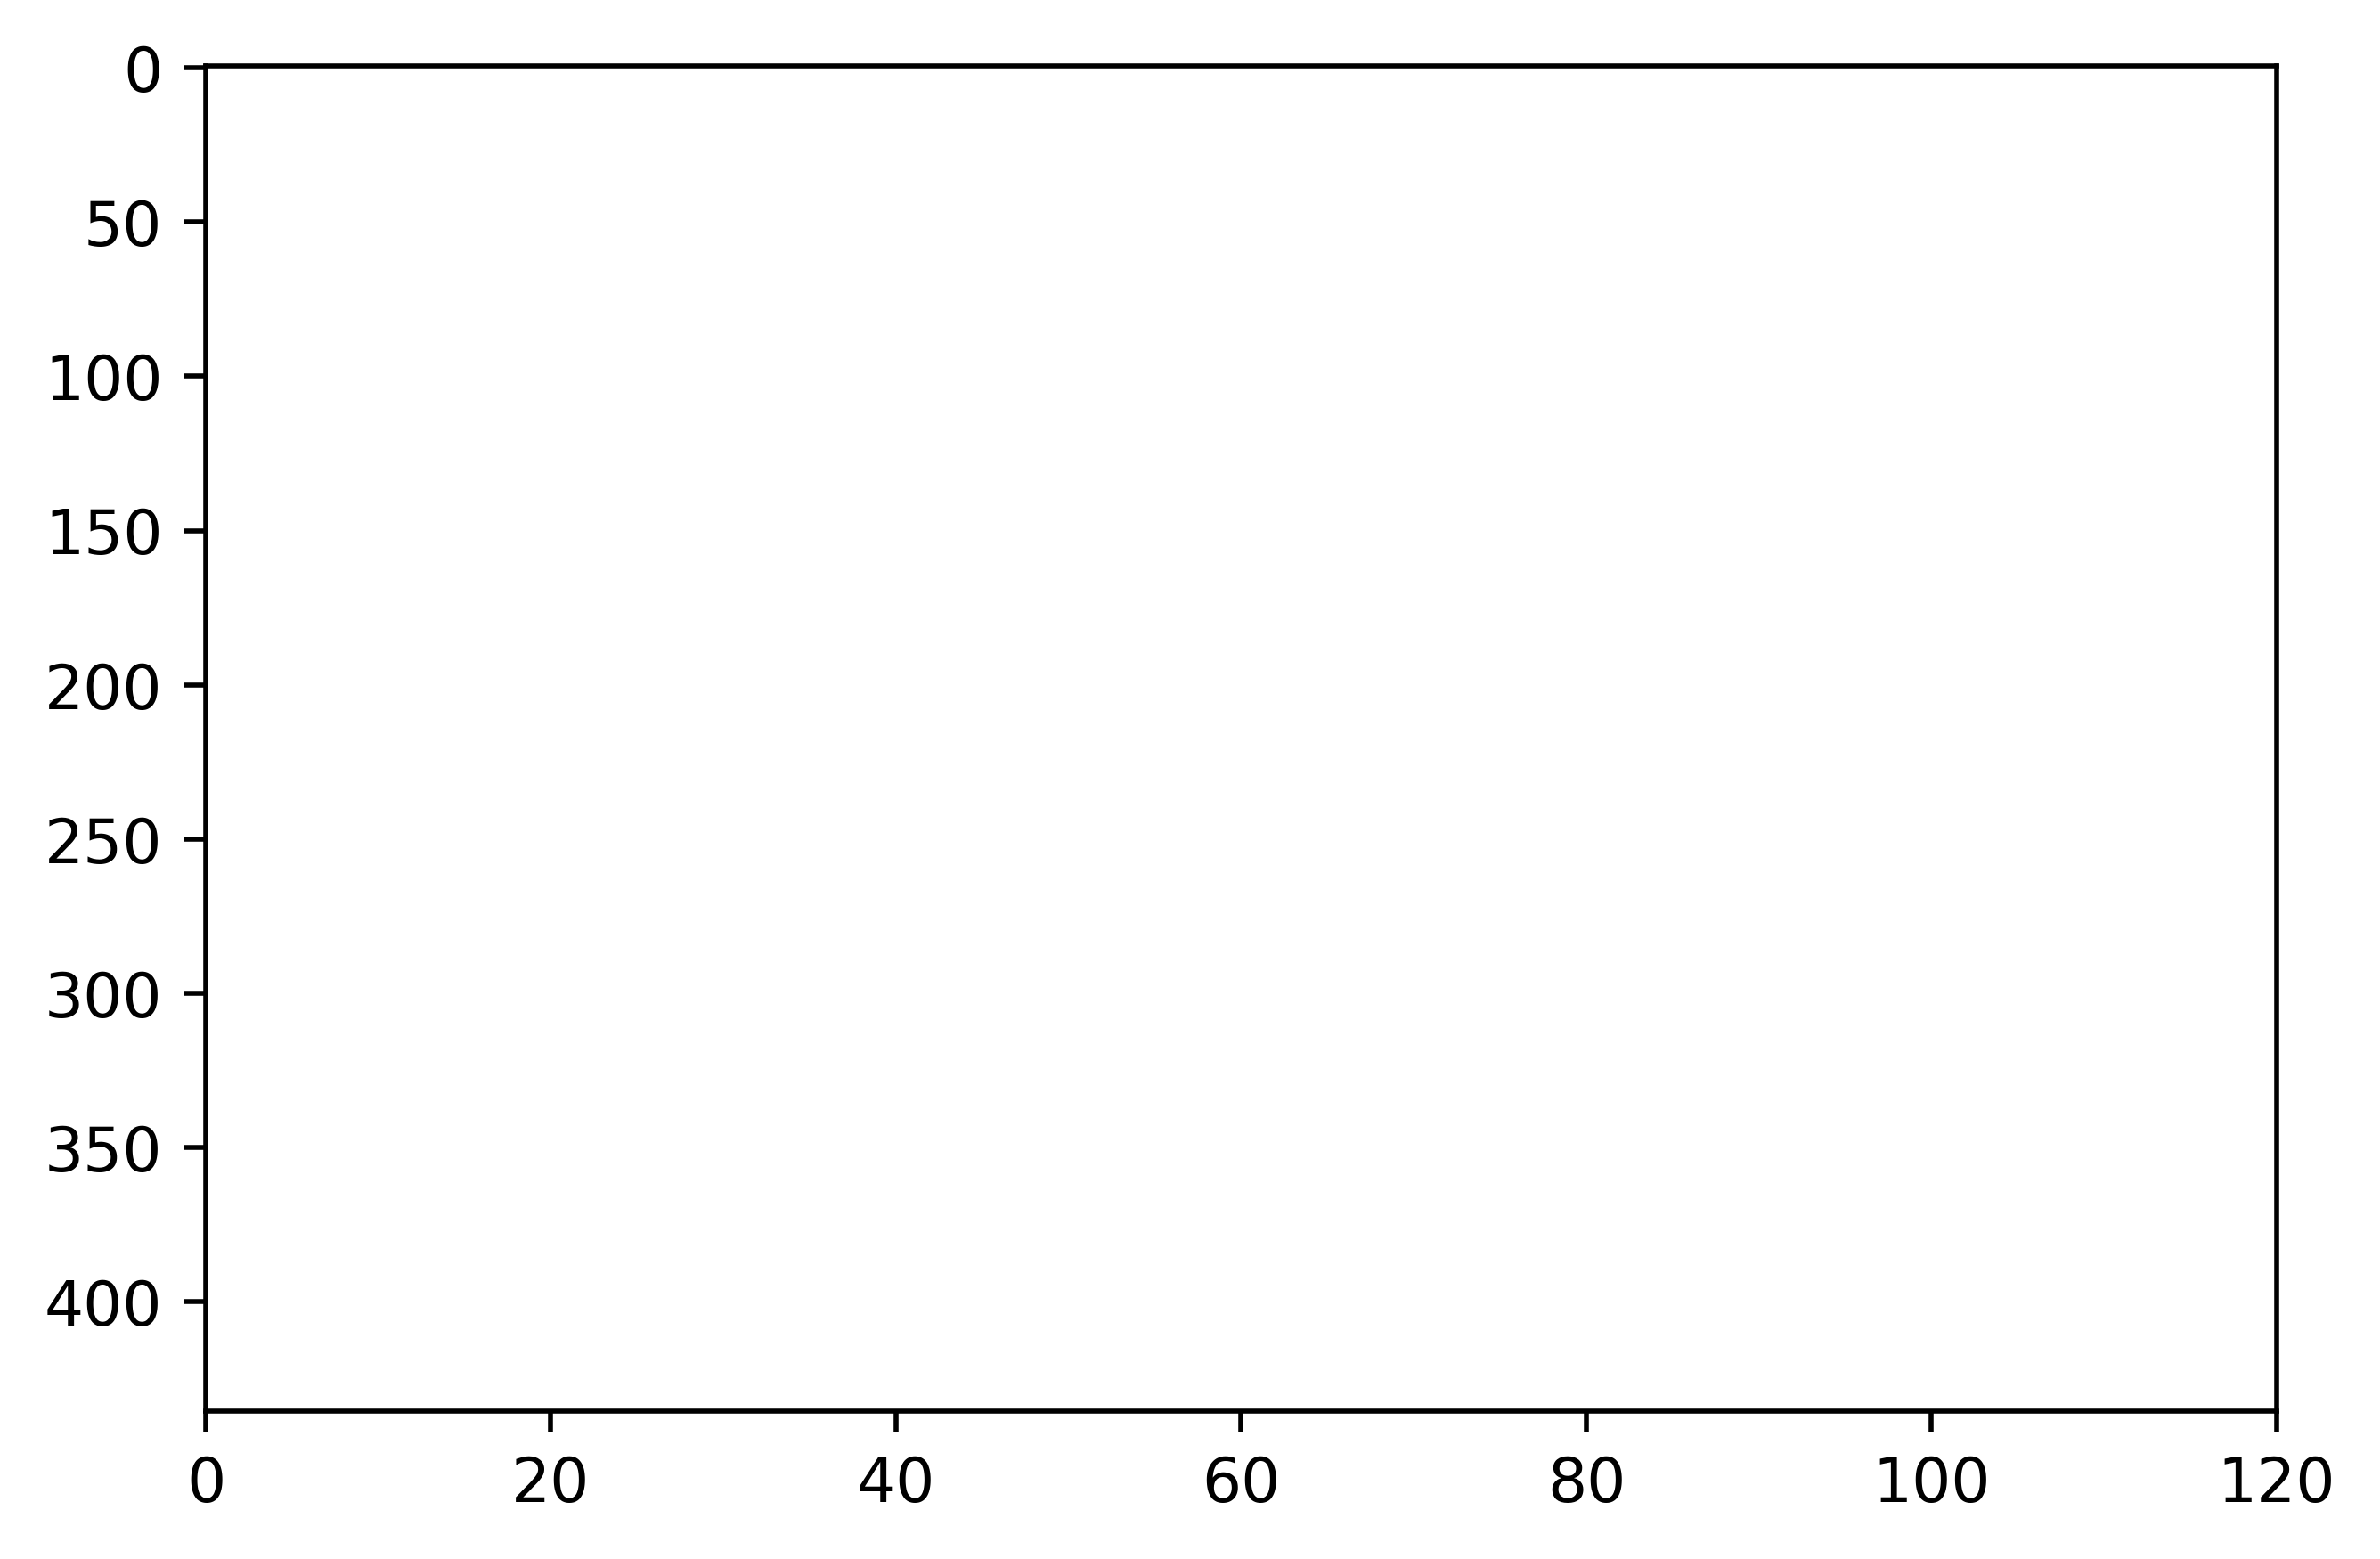

In [28]:
plt.figure(dpi=500)
plt.imshow((total1[0]/total1[1]).T,aspect='auto',cmap='jet')
plt.xlim(0,120)
#plt.savefig('PaperPlots/LandOceanDiff/Total.png')

plt.figure(dpi=500)
plt.imshow((total1[2]/total1[3]).T,aspect='auto',cmap='jet')
plt.xlim(0,120)
#plt.savefig('PaperPlots/LandOceanDiff/LandAmt.png')

plt.figure(dpi=500)
plt.imshow((total1[4]/total1[5]).T,aspect='auto',cmap='seismic',vmax=0.3,vmin=-0.3)
plt.xlim(0,120)
#plt.savefig('PaperPlots/LandOceanDiff/OceanAmt.png')

In [ ]:
year_icnc = np.zeros((8,501,436))
for i in range(1,12):
    test = nc.Dataset('/net/seldon/disk2/Users/gah20/DARDARHIST/icnc2_histogram_OvL'+str(i).zfill(2)+'.nc')
    print(test)
    array = test['__xarray_dataarray_variable__']
    month = np.sum(array,axis=0)
    year_icnc = year_icnc + month

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): dim_0(367), dim_1(8), dim_2(501), dim_3(436)
    variables(dimensions): float64 __xarray_dataarray_variable__(dim_0, dim_1, dim_2, dim_3)
    groups: 


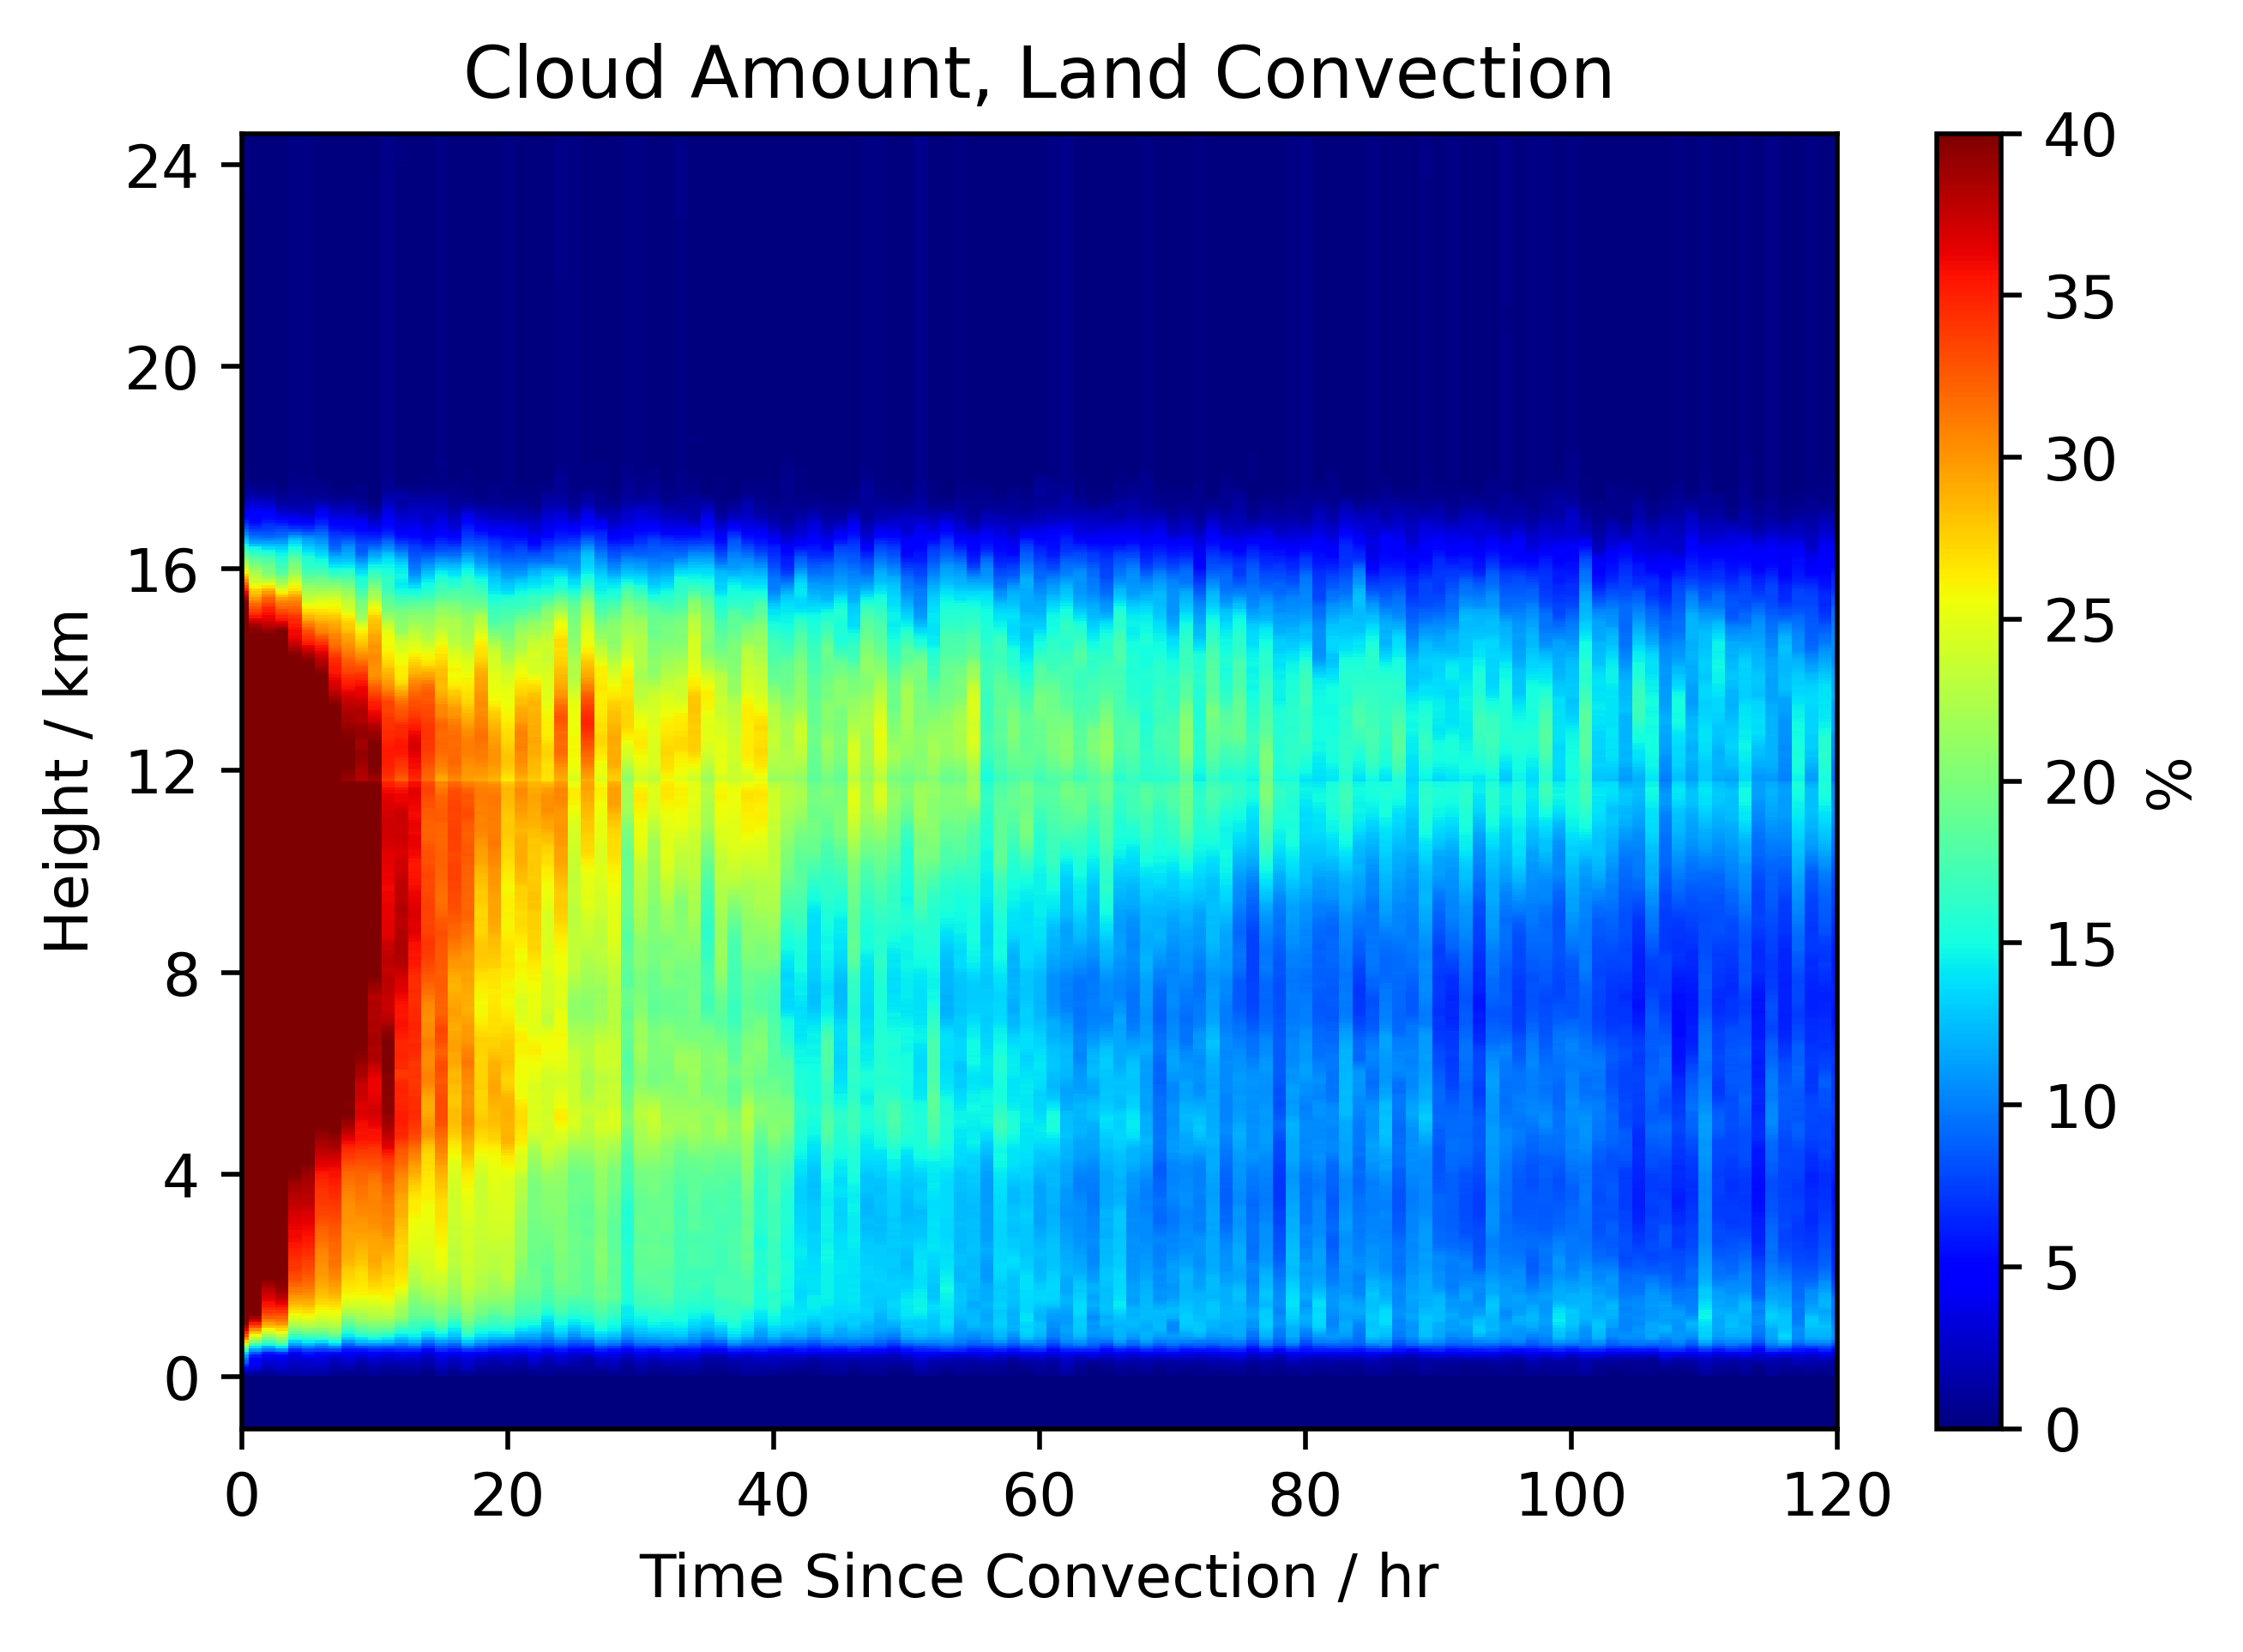

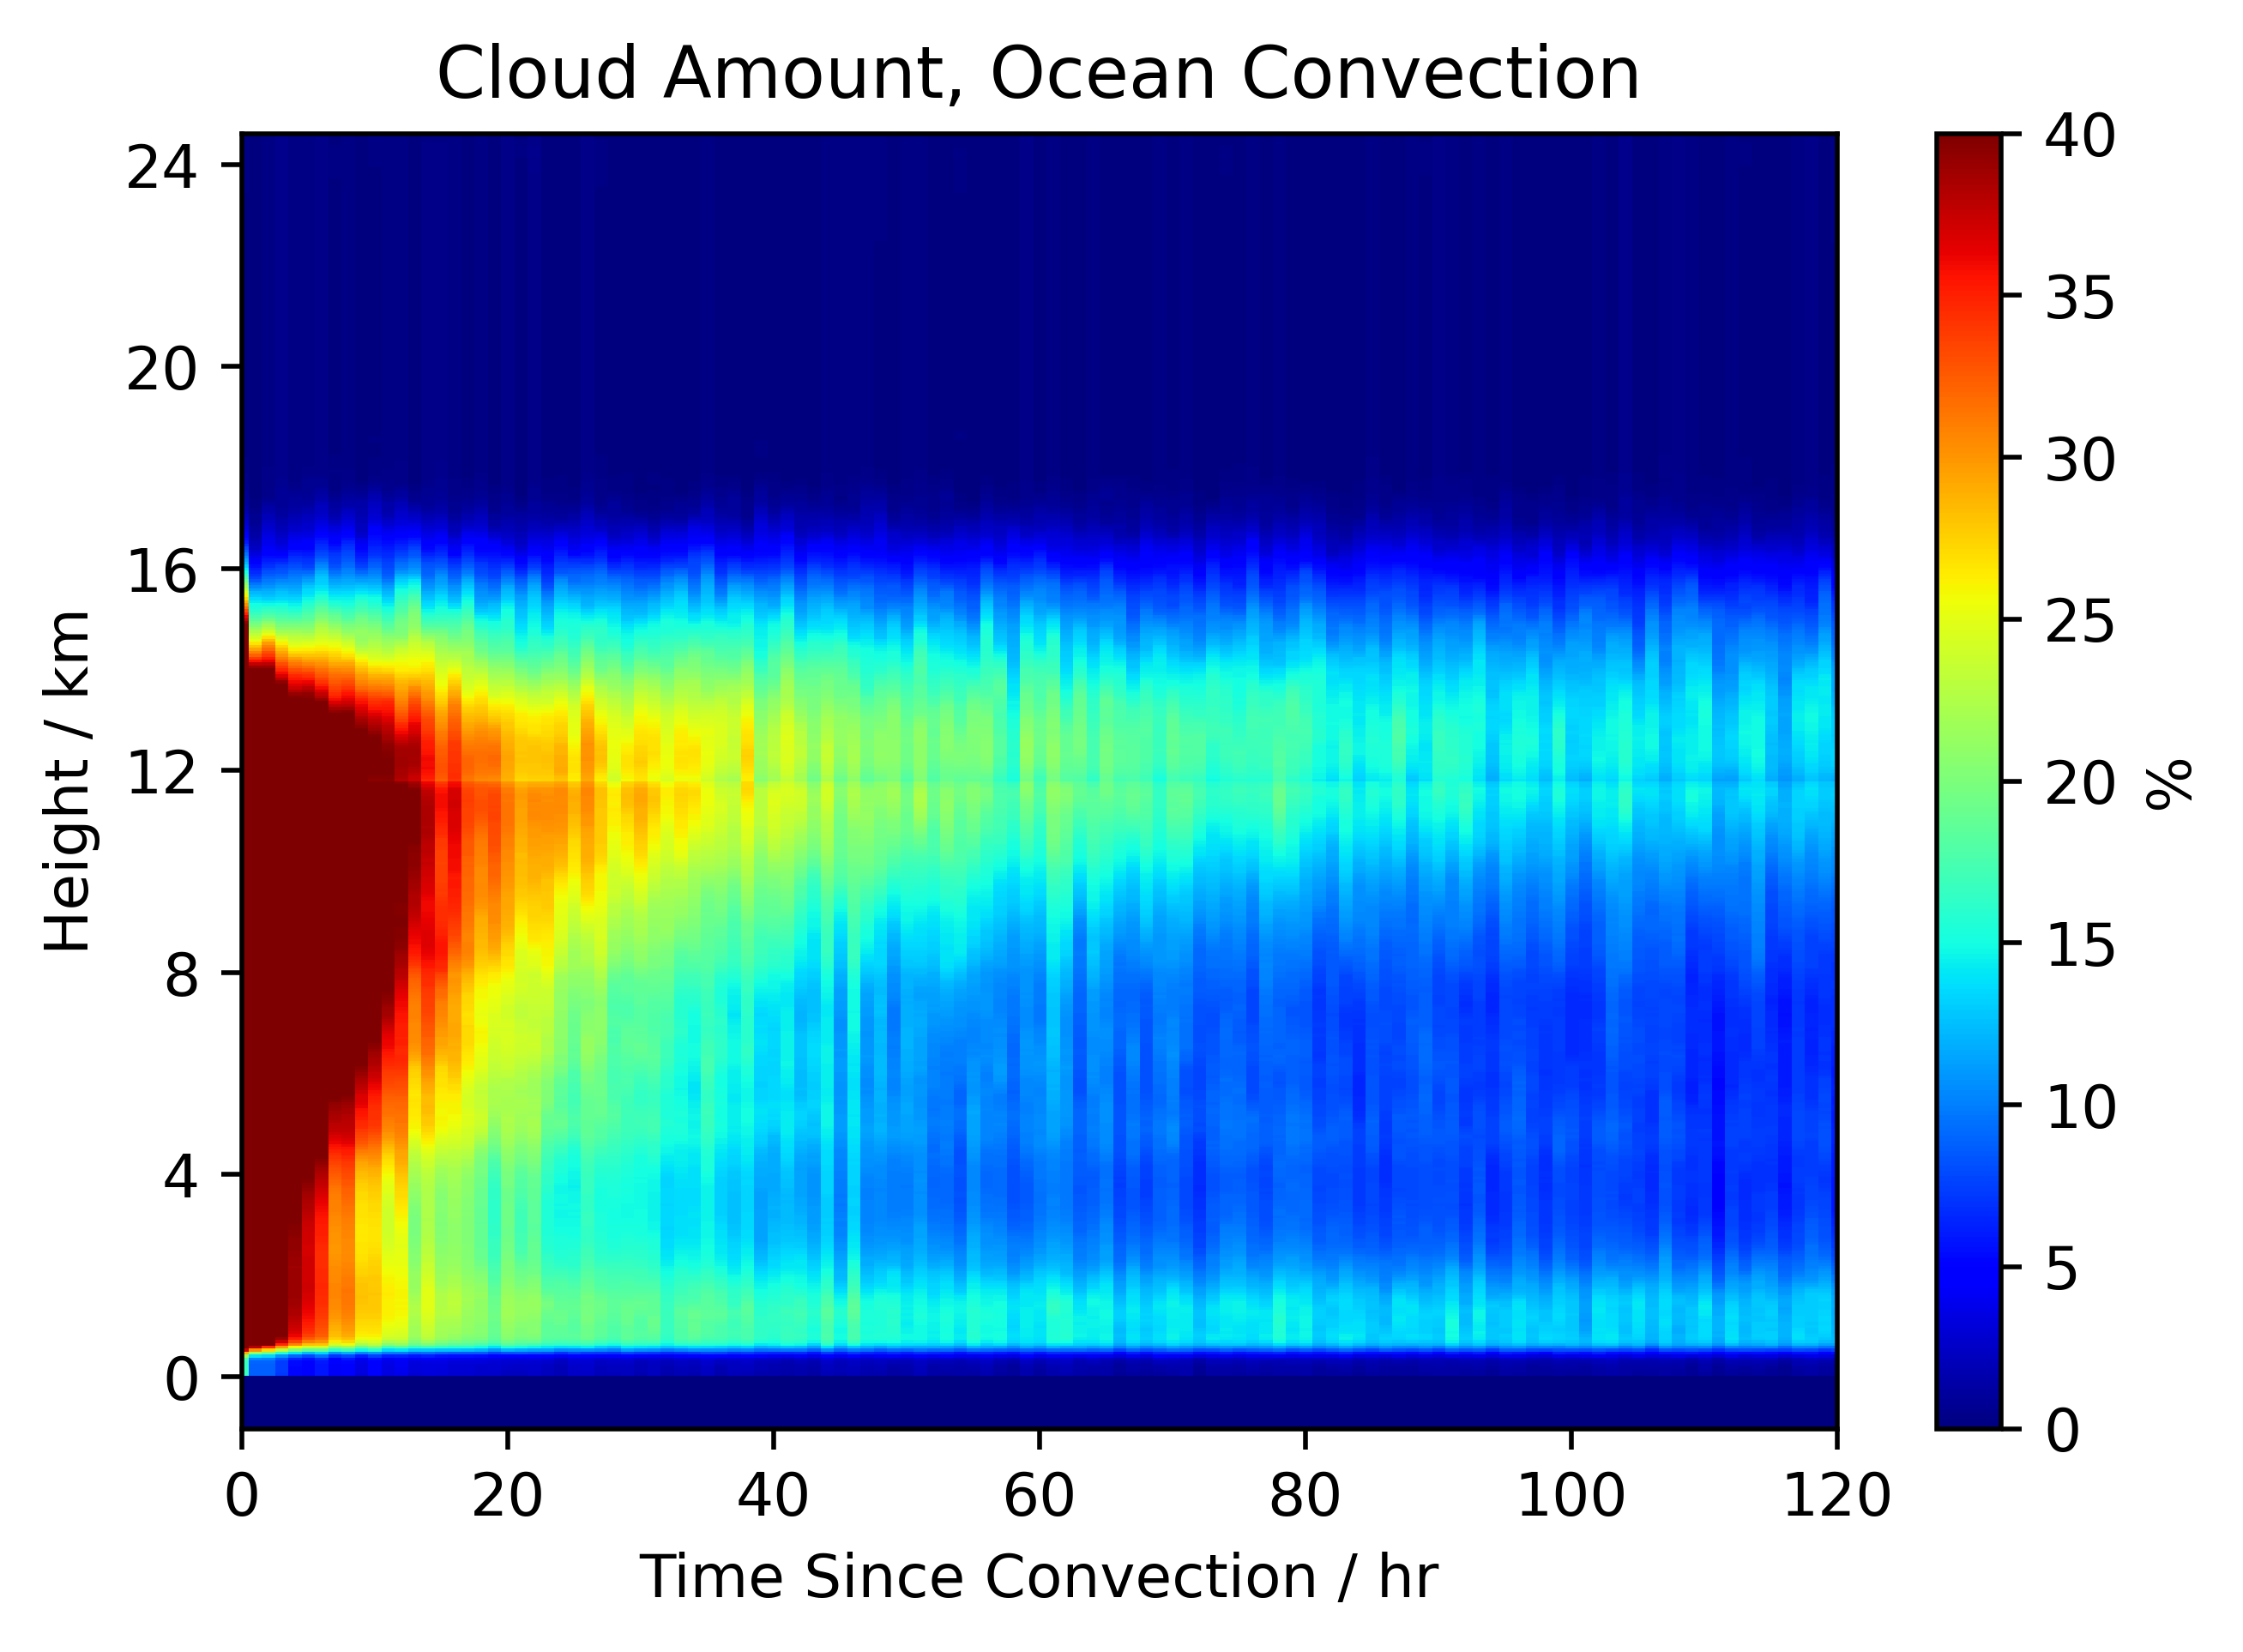

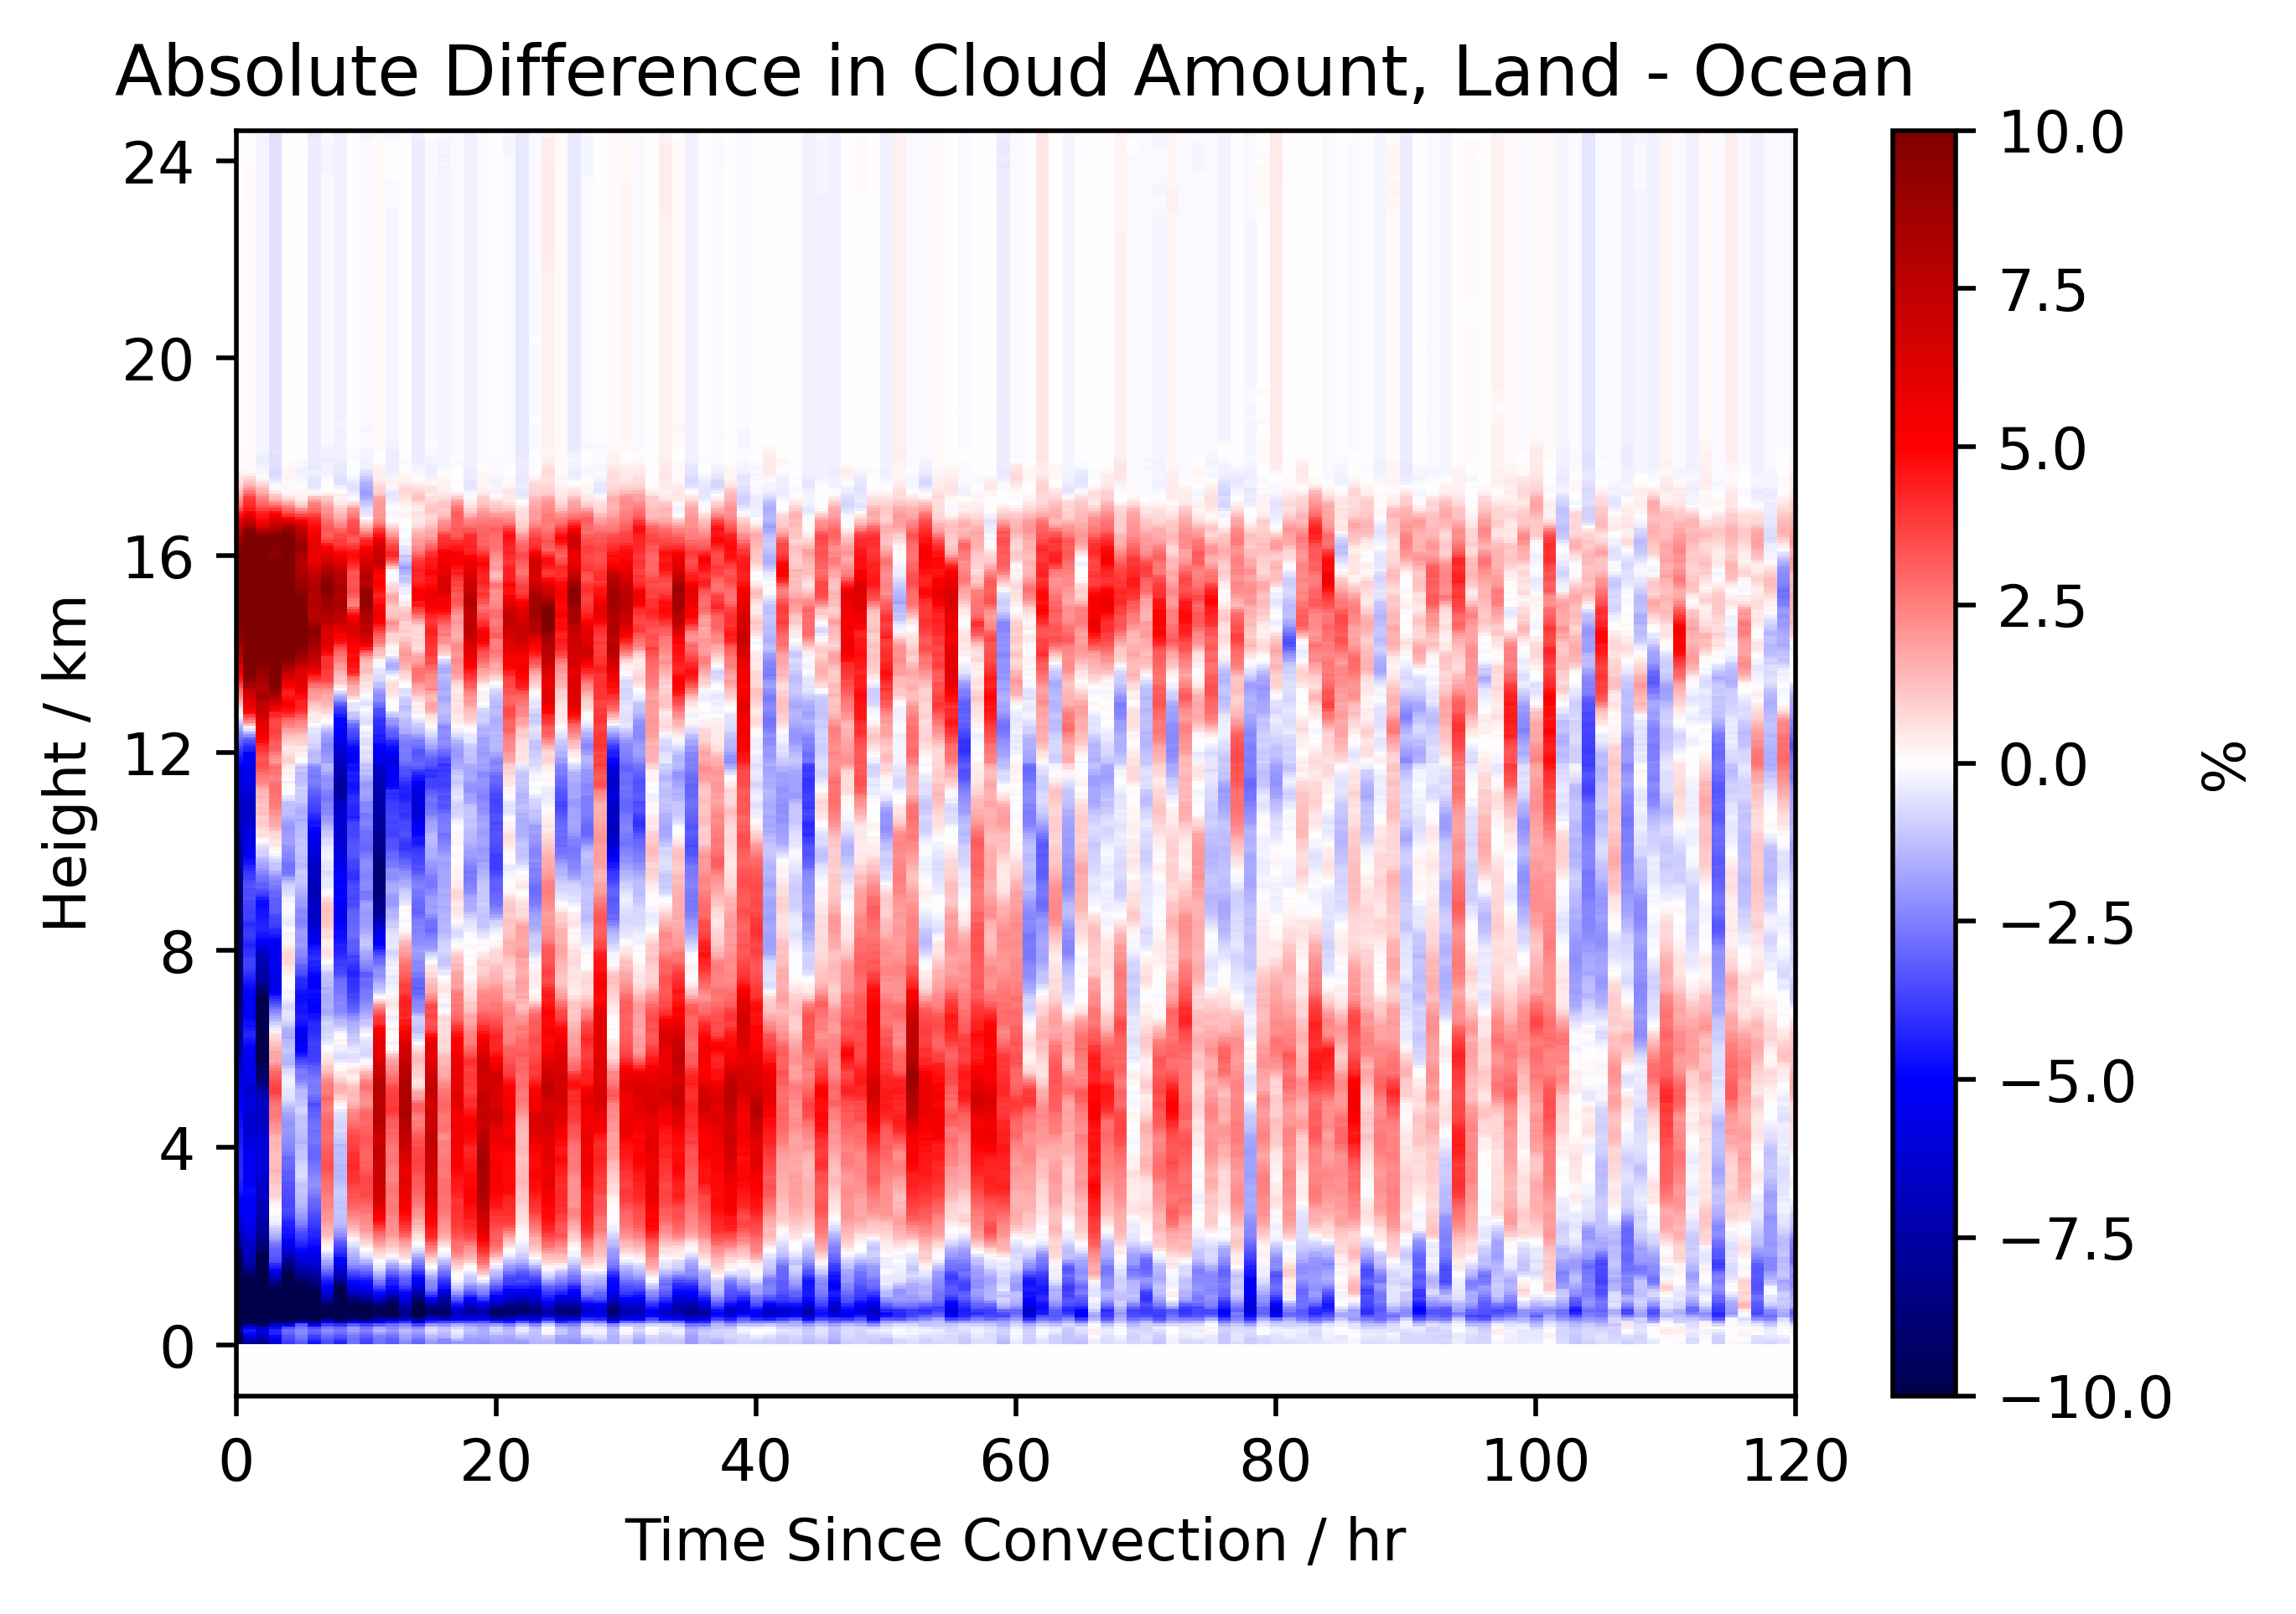

In [34]:
plt.figure(dpi=500)
im=plt.imshow((year_icnc[0]/year_icnc[1]).T * 100,aspect='auto',vmax=40,cmap='jet')
plt.xlim(0,120)
plt.colorbar(im,label='%')
plt.yticks(np.arange(418,0,-17*4),labels=(np.arange(0,26,4)))
plt.xlabel('Time Since Convection / hr')
plt.ylabel('Height / km')
#plt.xticks(np.arange(-0.5,30.5,6),labels=(np.arange(0,144,24)))
plt.title('Cloud Amount, Land Convection')
plt.savefig('PaperPlots/LandOceanDiff/DARDAR/LandAmt.png')


plt.figure(dpi=500)
im=plt.imshow((year_icnc[2]/year_icnc[3]).T * 100,aspect='auto',vmax=40,cmap='jet')
plt.xlim(0,120)
plt.colorbar(im,label='%')
plt.yticks(np.arange(418,0,-17*4),labels=(np.arange(0,26,4)))
#plt.xticks(np.arange(-0.5,30.5,6),labels=(np.arange(0,144,24)))
plt.xlabel('Time Since Convection / hr')
plt.ylabel('Height / km')
plt.title('Cloud Amount, Ocean Convection')
plt.savefig('PaperPlots/LandOceanDiff/DARDAR/OceanAmt.png')


plt.figure(dpi=500)
im=plt.imshow((year_icnc[0]/year_icnc[1]).T * 100 - (year_icnc[2]/year_icnc[3]).T * 100,aspect='auto',vmin=-10,vmax=10,cmap='seismic')
plt.xlim(0,120)
plt.colorbar(im,label='%')
plt.yticks(np.arange(418,0,-17*4),labels=(np.arange(0,26,4)))
#plt.xticks(np.arange(-0.5,30.5,6),labels=(np.arange(0,144,24)))
plt.xlabel('Time Since Convection / hr')
plt.ylabel('Height / km')
plt.title('Absolute Difference in Cloud Amount, Land - Ocean')
plt.savefig('PaperPlots/LandOceanDiff/DARDAR/DiffAmt.png')

/home/gah20/.conda/envs/py3_jl/bin/xpython:2: RuntimeWarning: invalid value encountered in true_divide
/home/gah20/.conda/envs/py3_jl/bin/xpython:14: RuntimeWarning: invalid value encountered in true_divide
/home/gah20/.conda/envs/py3_jl/bin/xpython:26: RuntimeWarning: invalid value encountered in true_divide


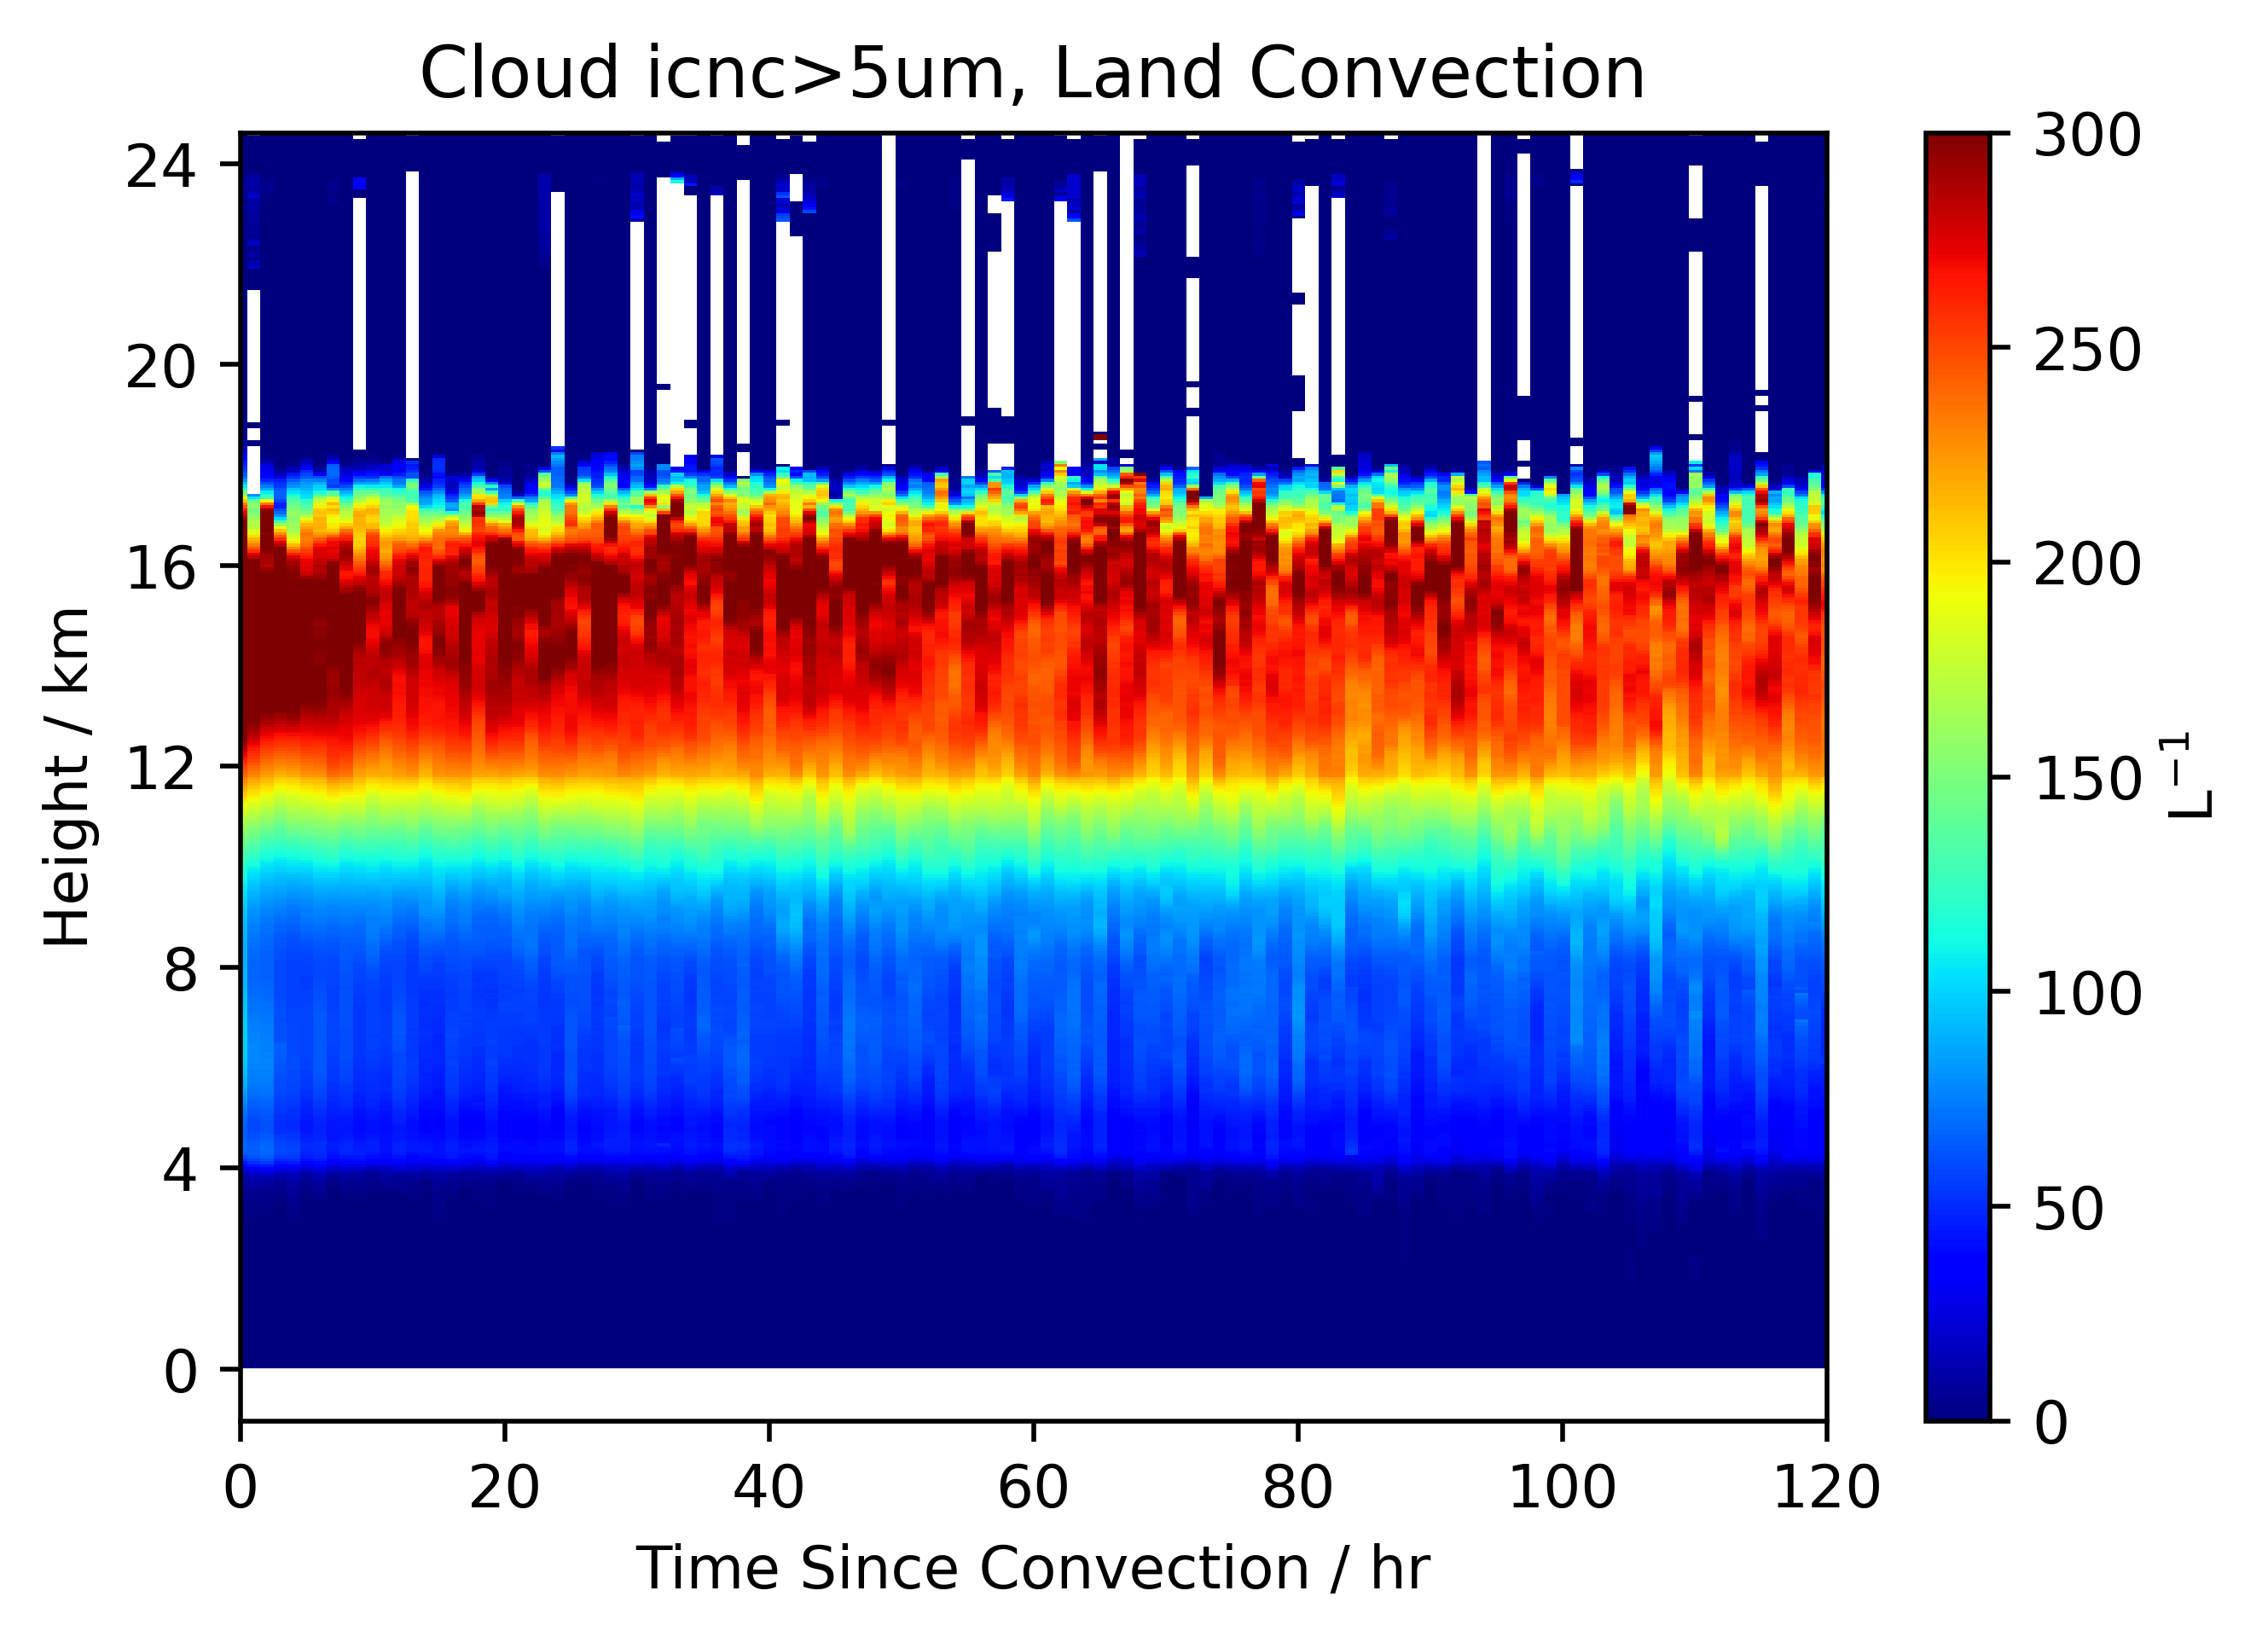

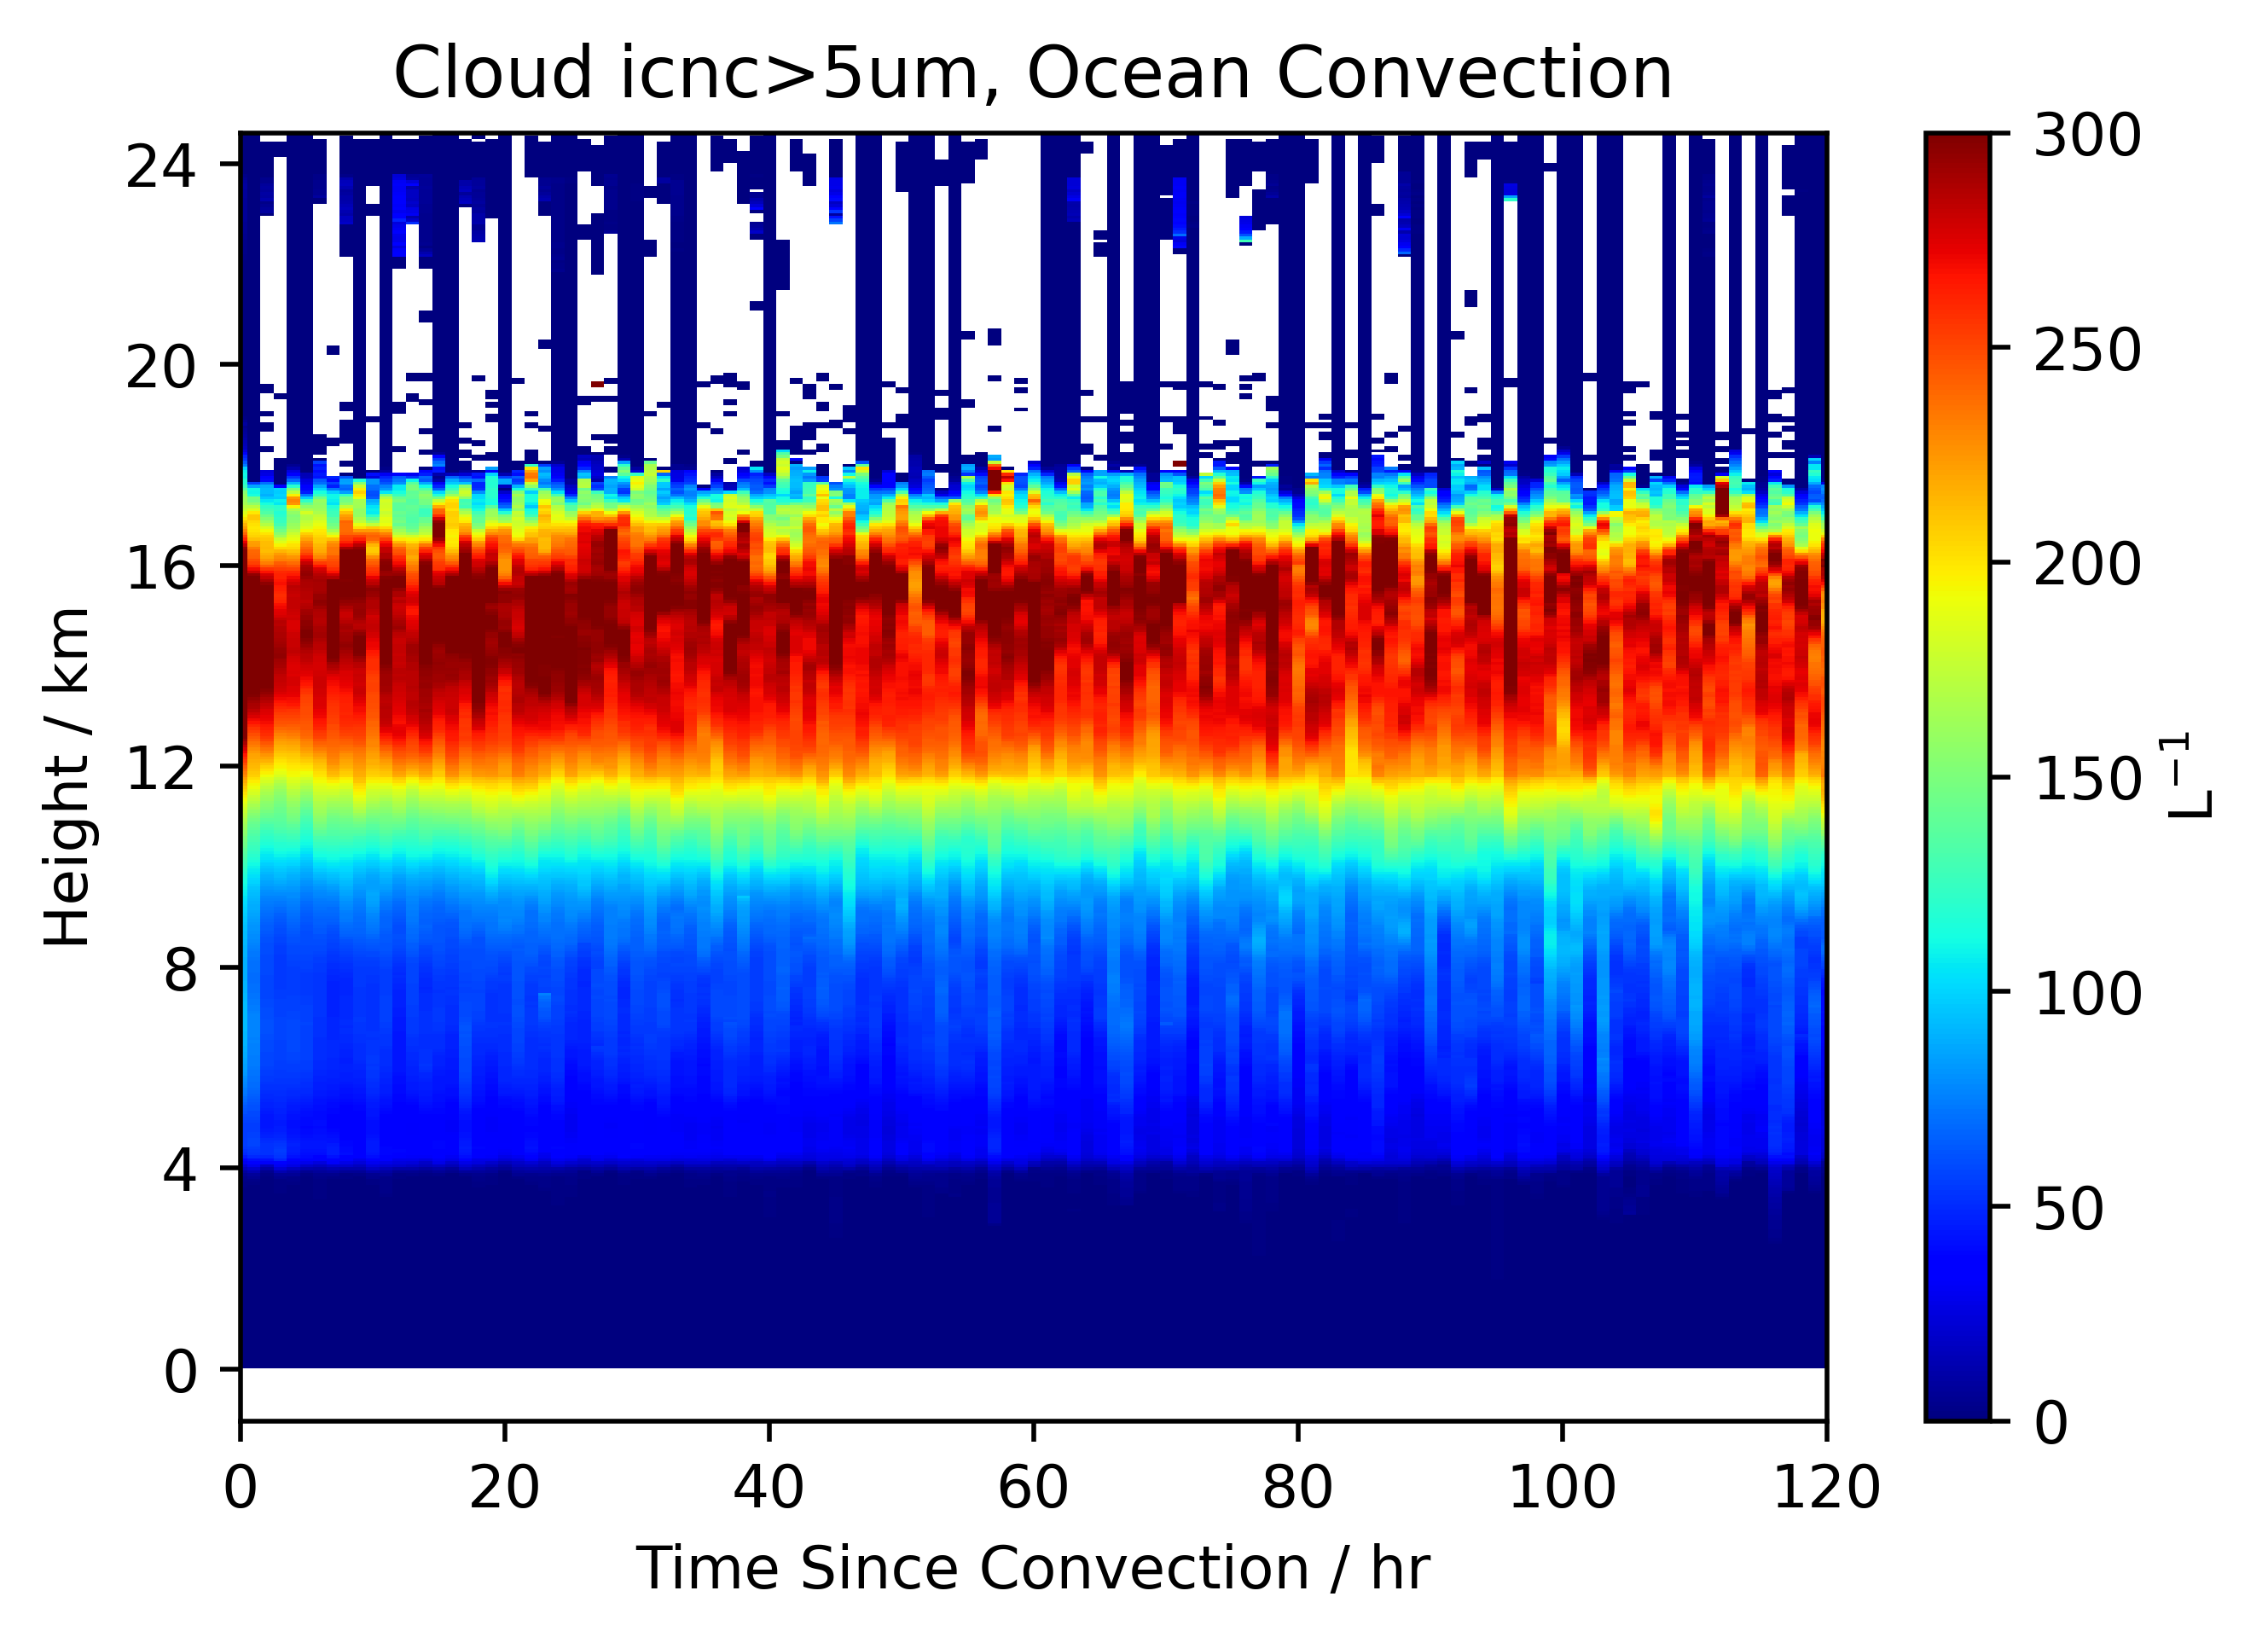

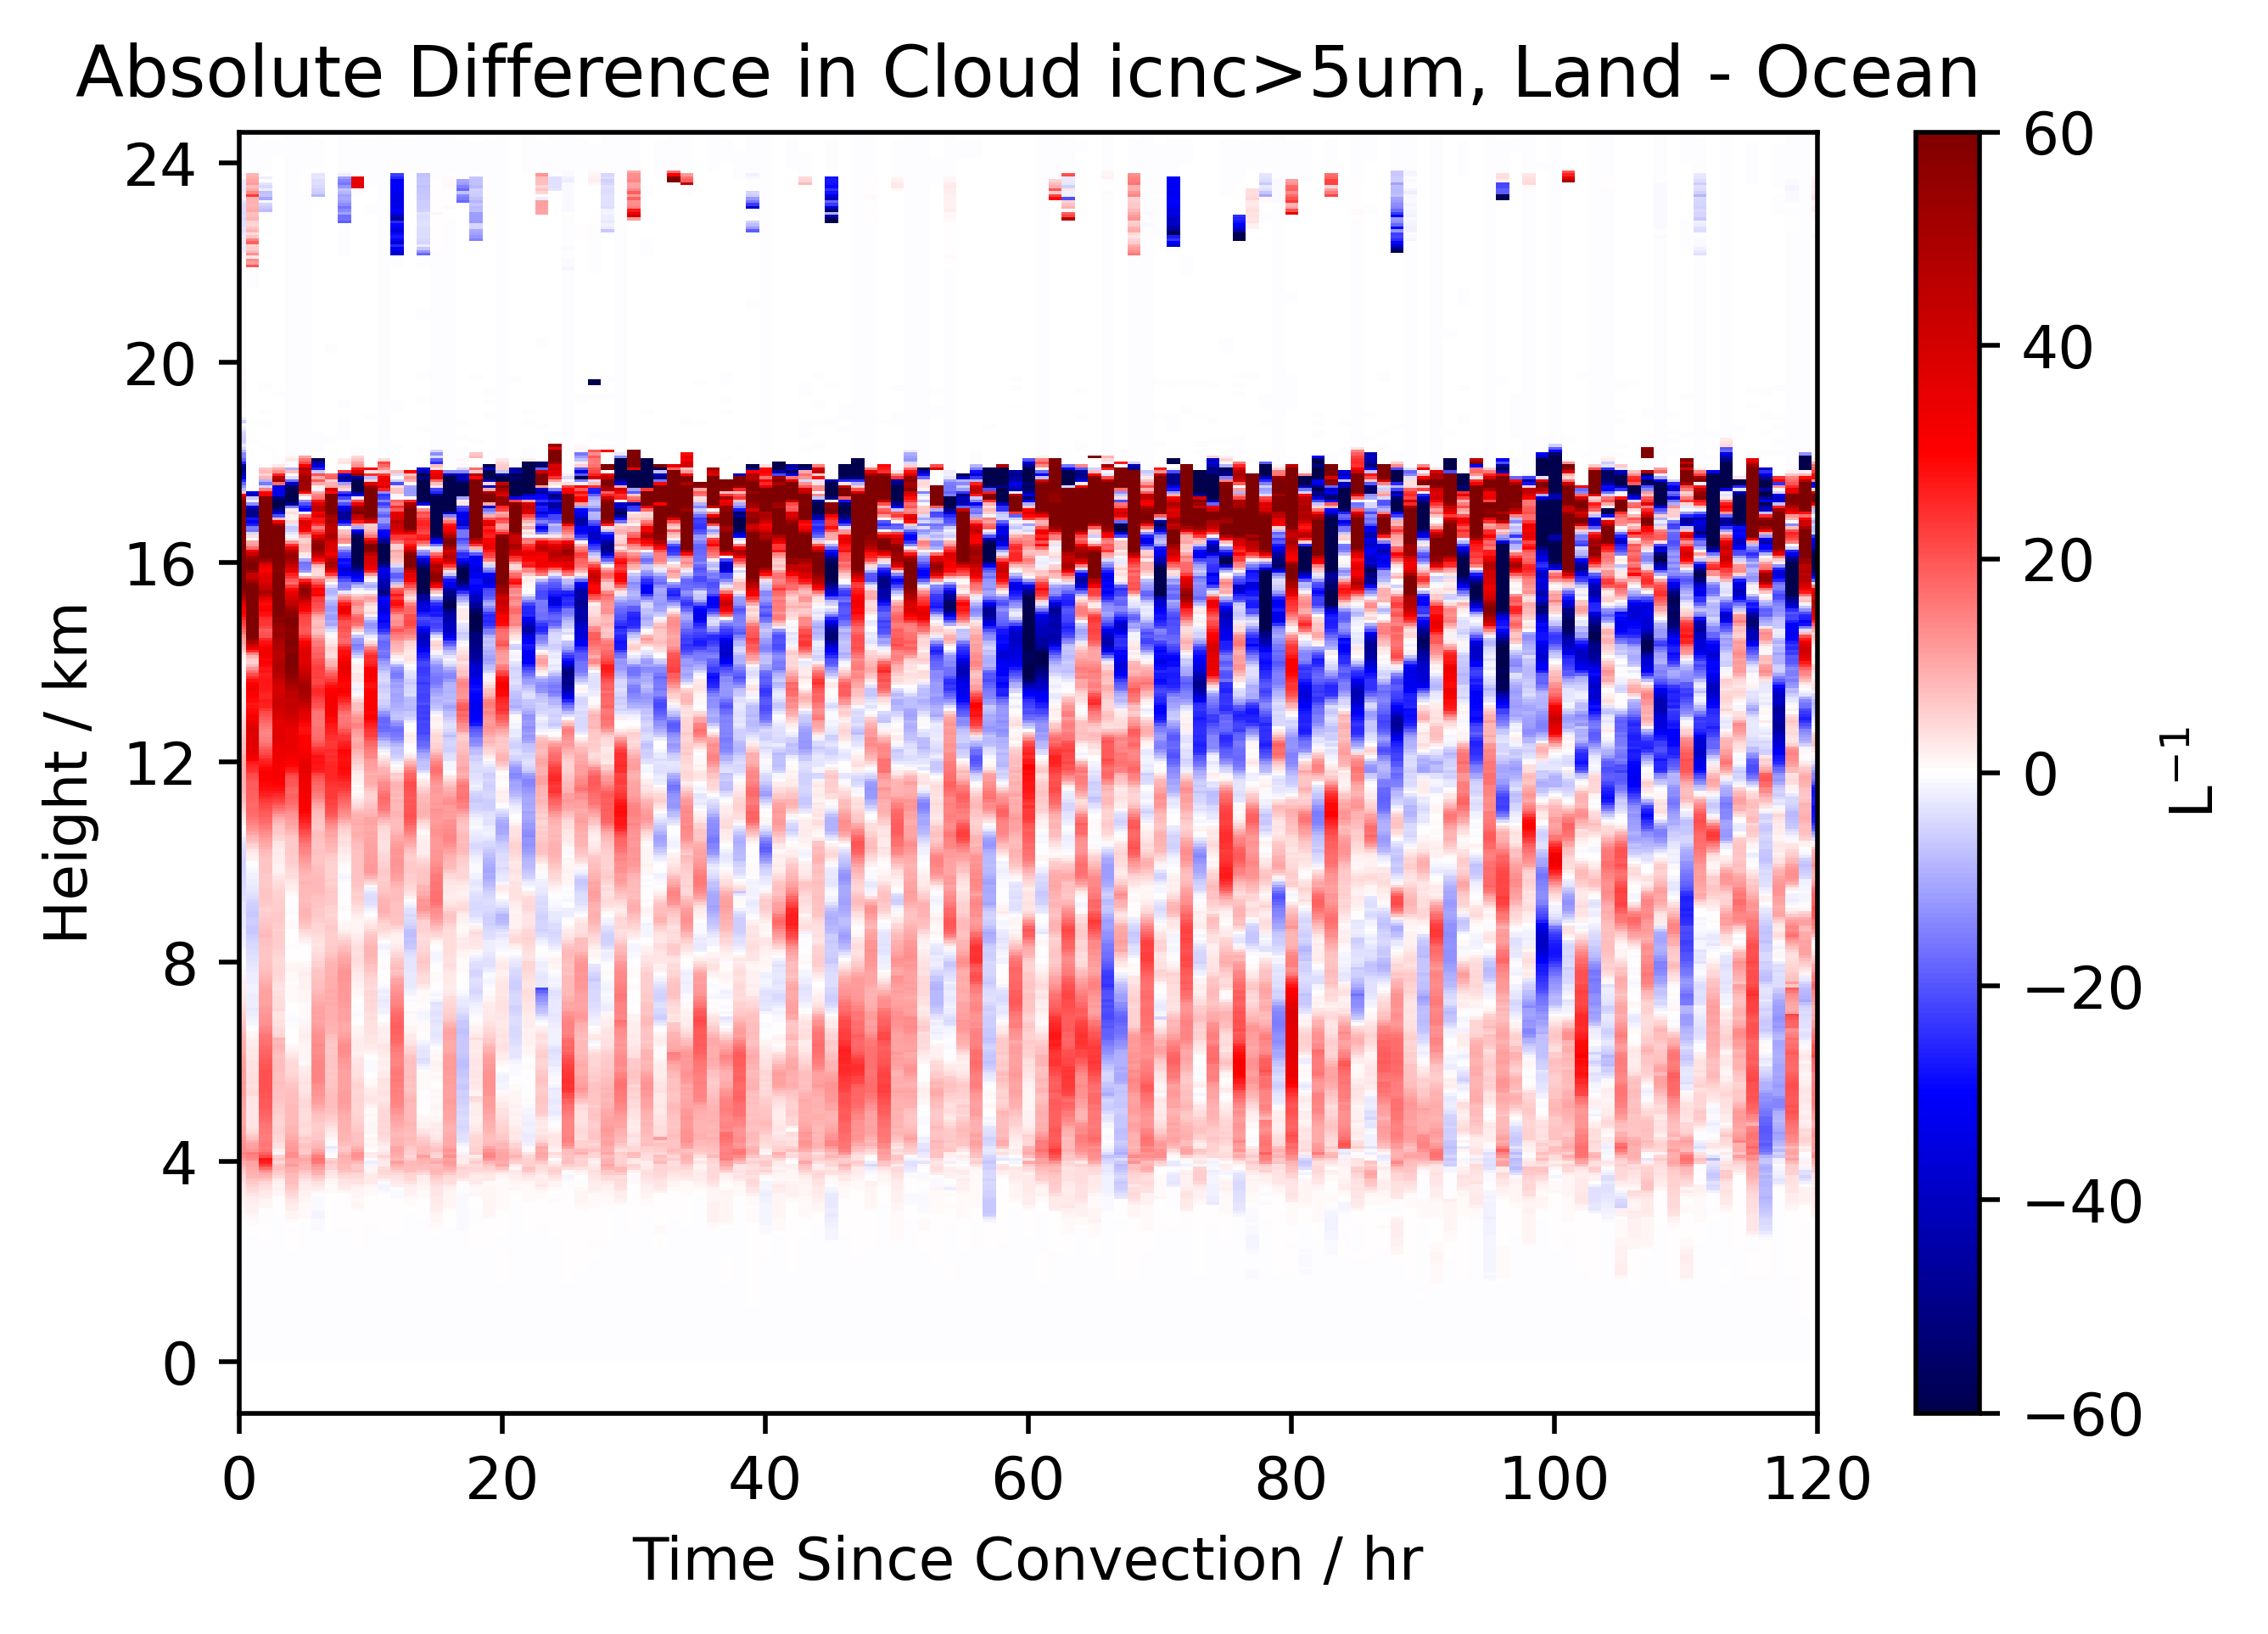

In [40]:
plt.figure(dpi=500)
im=plt.imshow((year_icnc[4]/year_icnc[5]).T / 1000,aspect='auto',vmax=300,cmap='jet')
plt.xlim(0,120)
plt.colorbar(im,label='L$^{-1}$')
plt.yticks(np.arange(418,0,-17*4),labels=(np.arange(0,26,4)))
plt.xlabel('Time Since Convection / hr')
plt.ylabel('Height / km')
#plt.xticks(np.arange(-0.5,30.5,6),labels=(np.arange(0,144,24)))
plt.title('Cloud icnc>5um, Land Convection')
plt.savefig('PaperPlots/LandOceanDiff/DARDAR/LandICNC.png')


plt.figure(dpi=500)
im=plt.imshow((year_icnc[6]/year_icnc[7]).T / 1000,aspect='auto',vmax=300,cmap='jet')
plt.xlim(0,120)
plt.colorbar(im,label='L$^{-1}$')
plt.yticks(np.arange(418,0,-17*4),labels=(np.arange(0,26,4)))
#plt.xticks(np.arange(-0.5,30.5,6),labels=(np.arange(0,144,24)))
plt.xlabel('Time Since Convection / hr')
plt.ylabel('Height / km')
plt.title('Cloud icnc>5um, Ocean Convection')
plt.savefig('PaperPlots/LandOceanDiff/DARDAR/OceanICNC.png')


plt.figure(dpi=500)
im=plt.imshow((year_icnc[4]/year_icnc[5]).T /1000 - (year_icnc[6]/year_icnc[7]).T /1000,aspect='auto',vmin=-60,vmax=60,cmap='seismic')
plt.xlim(0,120)
plt.colorbar(im,label='L$^{-1}$')
plt.yticks(np.arange(418,0,-17*4),labels=(np.arange(0,26,4)))
#plt.xticks(np.arange(-0.5,30.5,6),labels=(np.arange(0,144,24)))
plt.xlabel('Time Since Convection / hr')
plt.ylabel('Height / km')
plt.title('Absolute Difference in Cloud icnc>5um, Land - Ocean')
plt.savefig('PaperPlots/LandOceanDiff/DARDAR/DiffICNC.png')

In [4]:
year_icnc = np.zeros((6,501,350))
for i in range(1,12):
    test = nc.Dataset('/net/seldon/disk2/Users/gah20/DARDARHIST/icnc_hist'+str(i).zfill(2)+'.nc')
    print(test)
    array = test['__xarray_dataarray_variable__']
    month = np.sum(array,axis=0)
    year_icnc = year_icnc + month

FileNotFoundError: [Errno 2] No such file or directory: b'/net/seldon/disk2/Users/gah20/DARDARHIST/icnc_hist01.nc'

In [3]:
year_iwc = np.zeros((6,501,436))
for i in range(1,12):
    test = nc.Dataset('/net/seldon/disk2/Users/gah20/DARDARHIST/iwc_histogram'+str(i).zfill(2)+'.nc')
    print(test)
    array = test['__xarray_dataarray_variable__']
    month = np.sum(array,axis=0)
    year_iwc = year_iwc + month

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): dim_0(367), dim_1(6), dim_2(501), dim_3(436)
    variables(dimensions): float64 __xarray_dataarray_variable__(dim_0, dim_1, dim_2, dim_3)
    groups: 
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): dim_0(390), dim_1(6), dim_2(501), dim_3(436)
    variables(dimensions): float64 __xarray_dataarray_variable__(dim_0, dim_1, dim_2, dim_3)
    groups: 
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): dim_0(317), dim_1(6), dim_2(501), dim_3(436)
    variables(dimensions): float64 __xarray_dataarray_variable__(dim_0, dim_1, dim_2, dim_3)
    groups: 
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): dim_0(433), dim_1(6), dim_2(501), dim_3(436)
    variables(dimensions): float64 __xarray_dataarray_variable__(d

/home/gah20/.conda/envs/py3_jl/bin/xpython:1: RuntimeWarning: invalid value encountered in true_divide
/home/gah20/.conda/envs/py3_jl/bin/xpython:3: RuntimeWarning: Mean of empty slice
/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


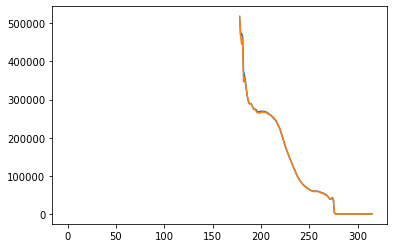

In [6]:
iwc = (year_icnc[2,0:120]/year_icnc[3,0:120])

iwc_mean = np.nanmean(iwc,axis=0)
iwc_median = np.nanmedian(iwc,axis=0)
plt.plot(iwc_mean)
plt.plot(iwc_median)

/home/gah20/.conda/envs/py3_jl/bin/xpython:1: RuntimeWarning: invalid value encountered in true_divide
/home/gah20/.conda/envs/py3_jl/bin/xpython:2: RuntimeWarning: invalid value encountered in true_divide
/home/gah20/.conda/envs/py3_jl/bin/xpython:4: RuntimeWarning: Mean of empty slice
/home/gah20/.conda/envs/py3_jl/bin/xpython:5: RuntimeWarning: Mean of empty slice


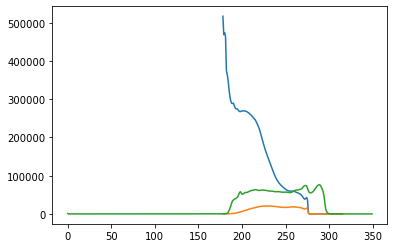

In [139]:
icnc5 = (year_icnc[2,0:120]/year_icnc[3,0:120])
icnc100 = (year_icnc[4,0:120]/year_icnc[5,0:120])
amt = year_icnc[0,0:120]
icnc5_mean = np.nanmean(icnc5,axis=0)
icnc100_mean = np.nanmean(icnc100,axis=0)
amt_mean = np.nanmean(amt,axis=0)
plt.plot(icnc5_mean)
plt.plot(icnc100_mean)
plt.plot(amt_mean)

In [48]:
icnc_int = interpolation.zoom(np.where(np.isnan(icnc5),0,icnc5),(0.5,1))

In [142]:
amt = year_icnc[1,0:121]
icnc5 = np.where(np.isnan(year_icnc[2,0:121]/year_icnc[3,0:121]),0,year_icnc[2,0:121]/year_icnc[3,0:121])
icnc100 = np.where(np.isnan(year_icnc[4,0:121]/year_icnc[5,0:121]),0,year_icnc[4,0:121]/year_icnc[5,0:121])

/home/gah20/.conda/envs/py3_jl/bin/xpython:2: RuntimeWarning: invalid value encountered in true_divide
/home/gah20/.conda/envs/py3_jl/bin/xpython:3: RuntimeWarning: invalid value encountered in true_divide


In [143]:
icnc5_mean = np.nanmean(icnc5,axis=0)
icnc100_mean = np.nanmean(icnc100,axis=0)

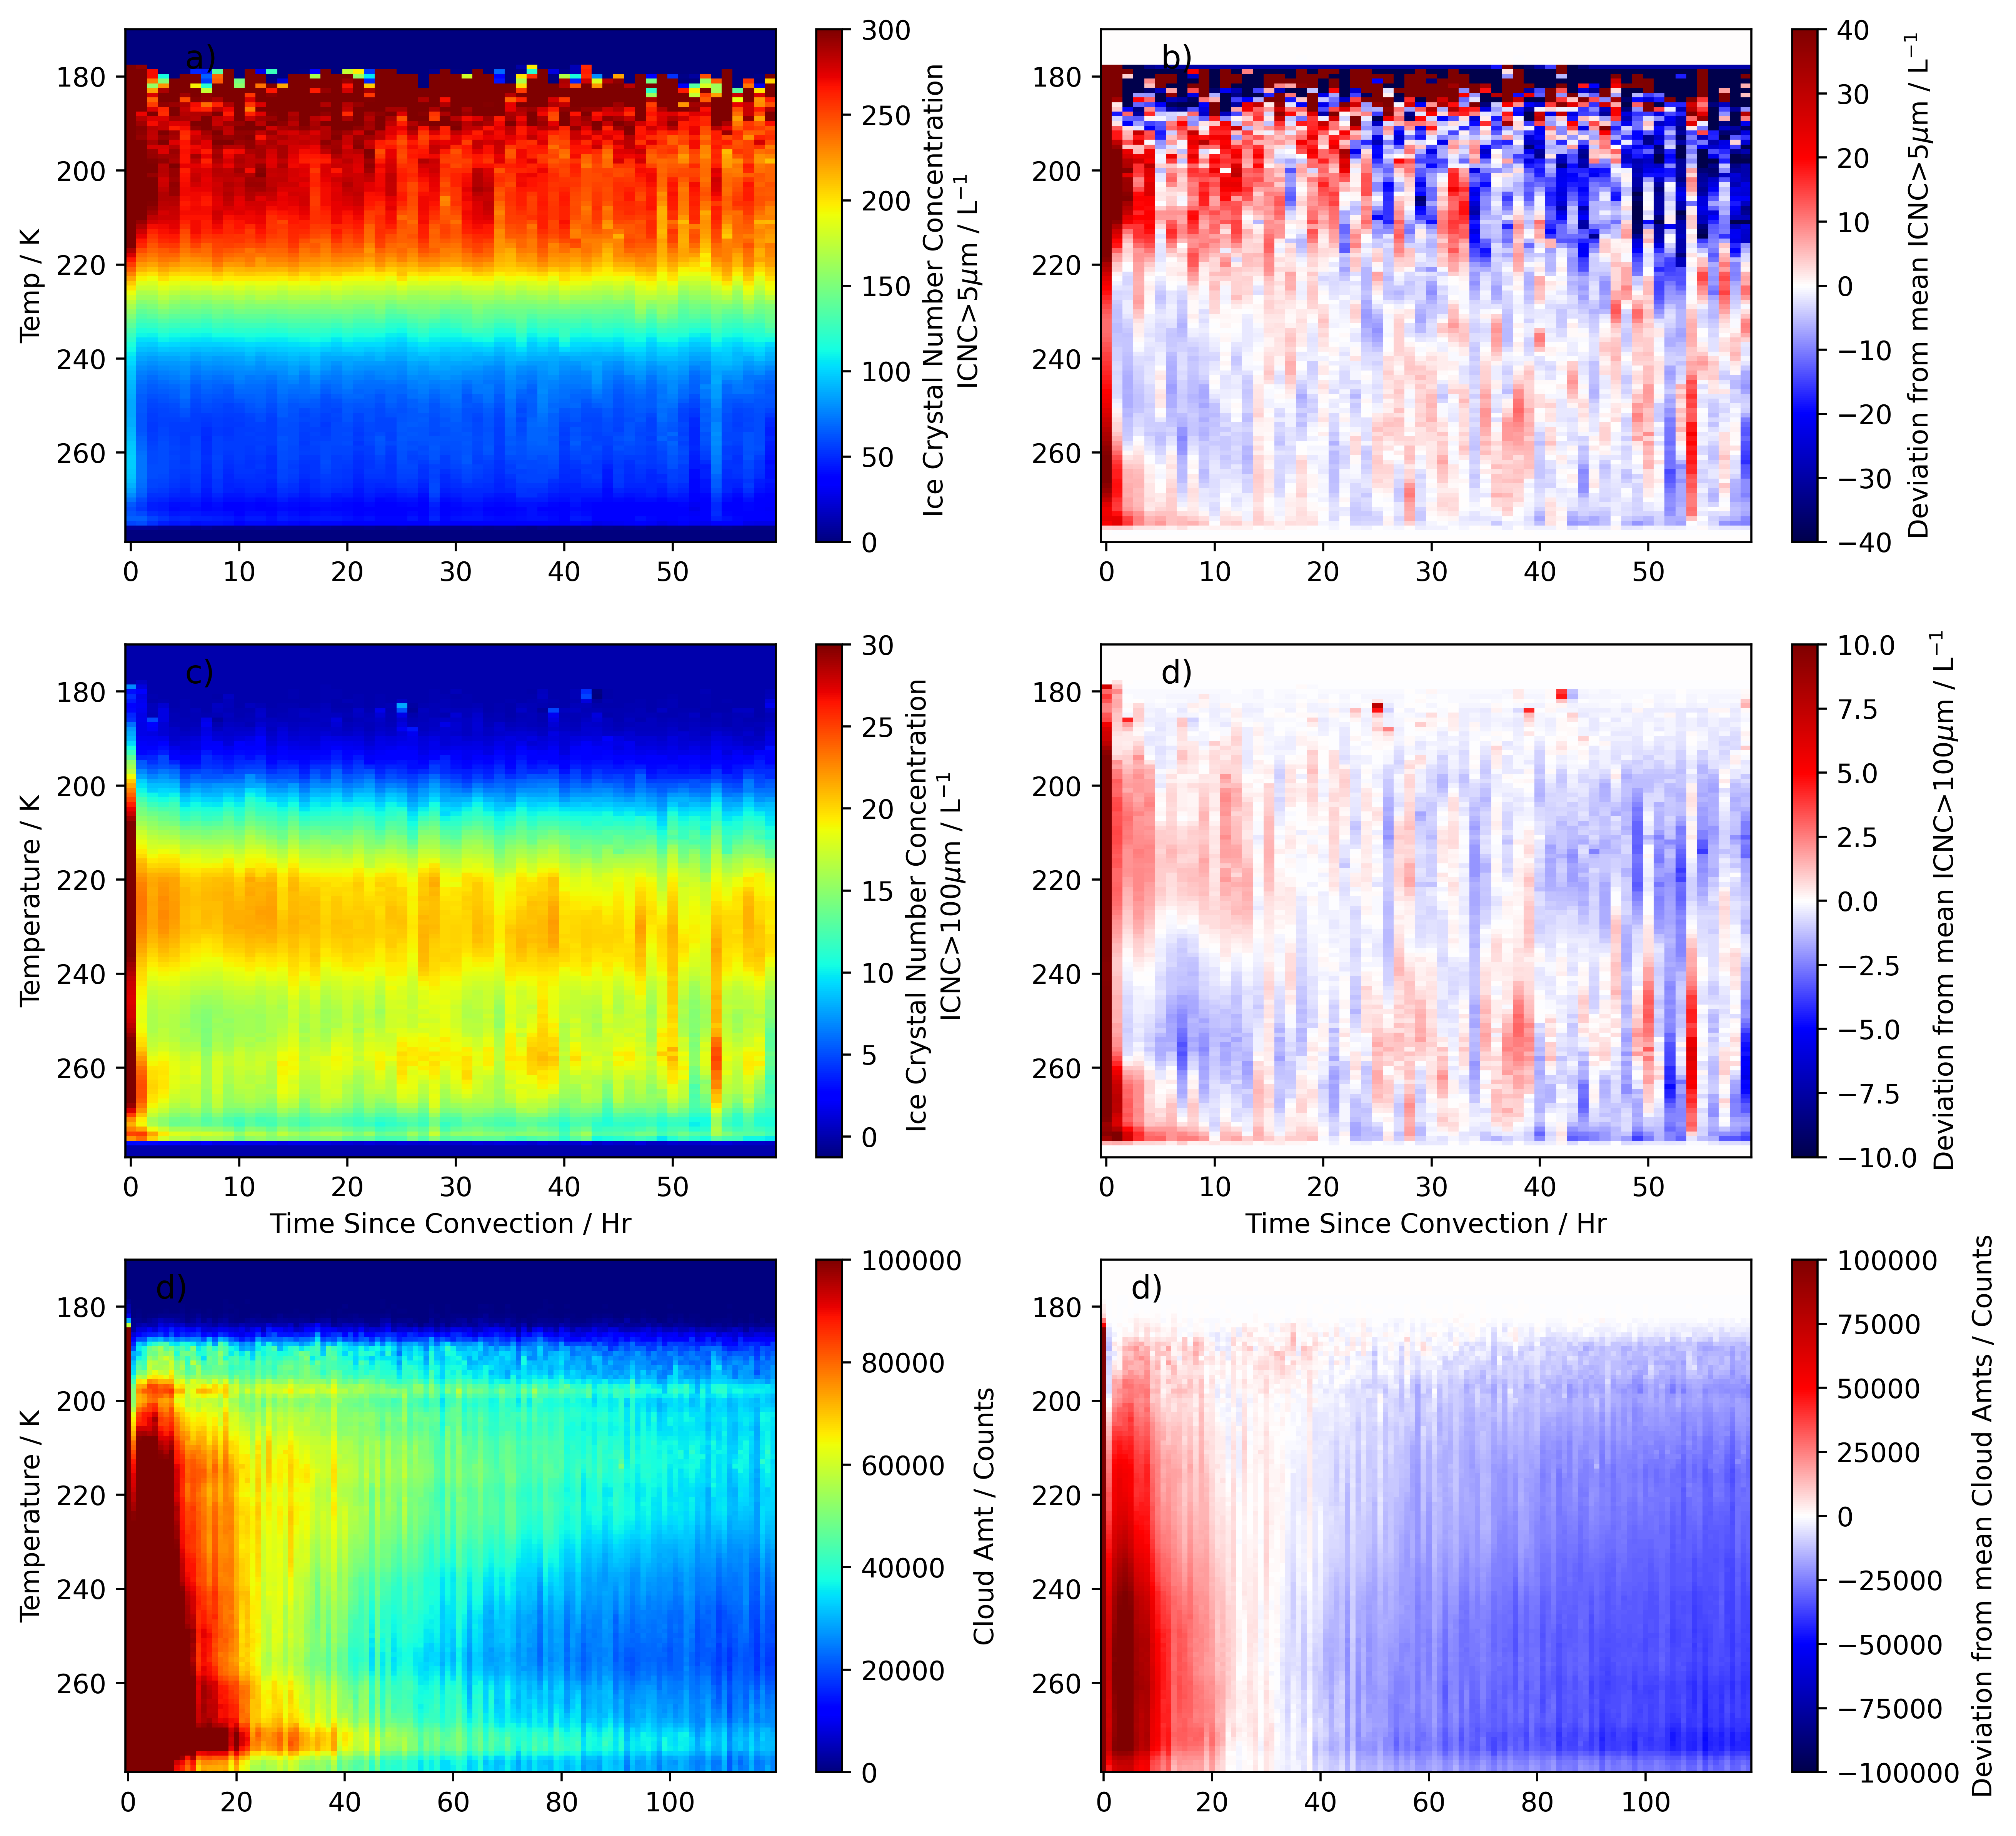

In [149]:
fig, axs = plt.subplots(3, 2,dpi=500,figsize=(12,12))

#im1 = axs[0,0].imshow((year_iwc[2,0:121]/year_iwc[3,0:121]).T / 1000,aspect='auto',interpolation='none',cmap='jet')
#fig.colorbar(im1, ax=axs[0, 0],label='Ice Water Content (IWC) / kgL$^{-1}$')
#plt.sca(axs[0,0])
#plt.yticks(np.arange(418,0,-17*4),labels=(np.arange(0,26,4)))
#plt.ylim(418,0)
#axs[0,0].text(0.05, 5, 'a)',
#      fontsize=12, color='white', va='top')

#im2 = axs[0,1].imshow(((year_iwc[2,0:121]/year_iwc[3,0:121]) - iwc_mean).T / 1000,aspect='auto',cmap='seismic',vmin=-1e-7,vmax=1e-7,interpolation='none')
#fig.colorbar(im2, ax=axs[0, 1],label='Deviation from mean IWC / kgL$^{-1}$')
#axs[2,0].set_xlabel('Time Since Convection / Hr')
#plt.sca(axs[0,1])
#plt.yticks(np.arange(418,0,-17*4),labels=(np.arange(0,26,4)))
#axs[0,0].set_ylabel('Height / km')
#plt.ylim(418,0)
#axs[0,1].text(0.05, 5, 'b)',
#      fontsize=12, color='black', va='top')

im3 = axs[0,0].imshow(ip.zoom((icnc5.T / 1000),(1,0.5)),aspect='auto',interpolation='none',cmap='jet',vmin=0,vmax=300)
fig.colorbar(im3, ax=axs[0, 0],label='Ice Crystal Number Concentration \n ICNC>5$\mu$m / L$^{-1}$')
plt.sca(axs[0,0])
#plt.yticks(np.arange(418,0,-17*4),labels=(np.arange(0,26,4)))
plt.ylim(279,170)
axs[0,0].text(5, 173, 'a)',
      fontsize=12, color='black', va='top')

im4 = axs[0,1].imshow(ip.zoom(((icnc5) - icnc5_mean).T / 1000,(1,0.5)),aspect='auto',cmap='seismic',vmin=-40,vmax=40,interpolation='none')
fig.colorbar(im4, ax=axs[0, 1],label='Deviation from mean ICNC>5$\mu$m / L$^{-1}$')
axs[1,1].set_xlabel('Time Since Convection / Hr')
plt.sca(axs[0,1])
#plt.yticks(np.arange(418,0,-17*4),labels=(np.arange(0,26,4)))
axs[0,0].set_ylabel('Temp / K')
plt.ylim(279,170)
#plt.ylim(418,0)
axs[0,1].text(5, 173, 'b)',
      fontsize=12, color='black', va='top')

im5 = axs[1,0].imshow(ip.zoom((icnc100.T / 1000),(1,0.5)),aspect='auto',interpolation='none',cmap='jet',vmax=30)
fig.colorbar(im5, ax=axs[1, 0],label='Ice Crystal Number Concentration \n ICNC>100$\mu$m / L$^{-1}$')
plt.sca(axs[1,0])
#plt.yticks(np.arange(418,0,-17*4),labels=(np.arange(0,26,4)))
#plt.ylim(418,0)
plt.ylim(279,170)
axs[1,0].set_xlabel('Time Since Convection / Hr')
axs[1,0].text(5, 173, 'c)',
      fontsize=12, color='black', va='top')

im6 = axs[1,1].imshow(ip.zoom(((icnc100) - icnc100_mean).T / 1000,(1,0.5)),aspect='auto',cmap='seismic',vmin=-10,vmax=10,interpolation='none')
fig.colorbar(im6, ax=axs[1, 1],label='Deviation from mean ICNC>100$\mu$m / L$^{-1}$')
plt.sca(axs[1,1])
axs[1,0].set_ylabel('Temperature / K')
#plt.yticks(np.arange(418,0,-17*4),labels=(np.arange(0,26,4)))
#plt.ylim(418,0)
plt.ylim(279,170)
axs[1,1].text(5, 173, 'd)',
      fontsize=12, color='black', va='top')

im7 = axs[2,0].imshow(year_icnc[0,0:120].T,aspect='auto',cmap='jet',vmax=100000,interpolation='none')
fig.colorbar(im7, ax=axs[2, 0],label='Cloud Amt / Counts')
plt.sca(axs[2,0])
axs[2,0].set_ylabel('Temperature / K')
#plt.yticks(np.arange(418,0,-17*4),labels=(np.arange(0,26,4)))
#plt.ylim(418,0)
plt.ylim(279,170)
axs[2,0].text(5, 173, 'd)',
      fontsize=12, color='black', va='top')

im8 = axs[2,1].imshow((year_icnc[0,0:120] - amt_mean).T,aspect='auto',cmap='seismic',vmin=-100000,vmax=100000,interpolation='none')
fig.colorbar(im8, ax=axs[2, 1],label='Deviation from mean Cloud Amts / Counts')
plt.sca(axs[2,1])
axs[2,0].set_ylabel('Temperature / K')
#plt.yticks(np.arange(418,0,-17*4),labels=(np.arange(0,26,4)))
#plt.ylim(418,0)
plt.ylim(279,170)
axs[2,1].text(5, 173, 'd)',
      fontsize=12, color='black', va='top')

plt.savefig("PaperPlots/DARDAR/COMBOTemp.png")

/home/gah20/.conda/envs/py3_jl/bin/xpython:2: RuntimeWarning: invalid value encountered in true_divide


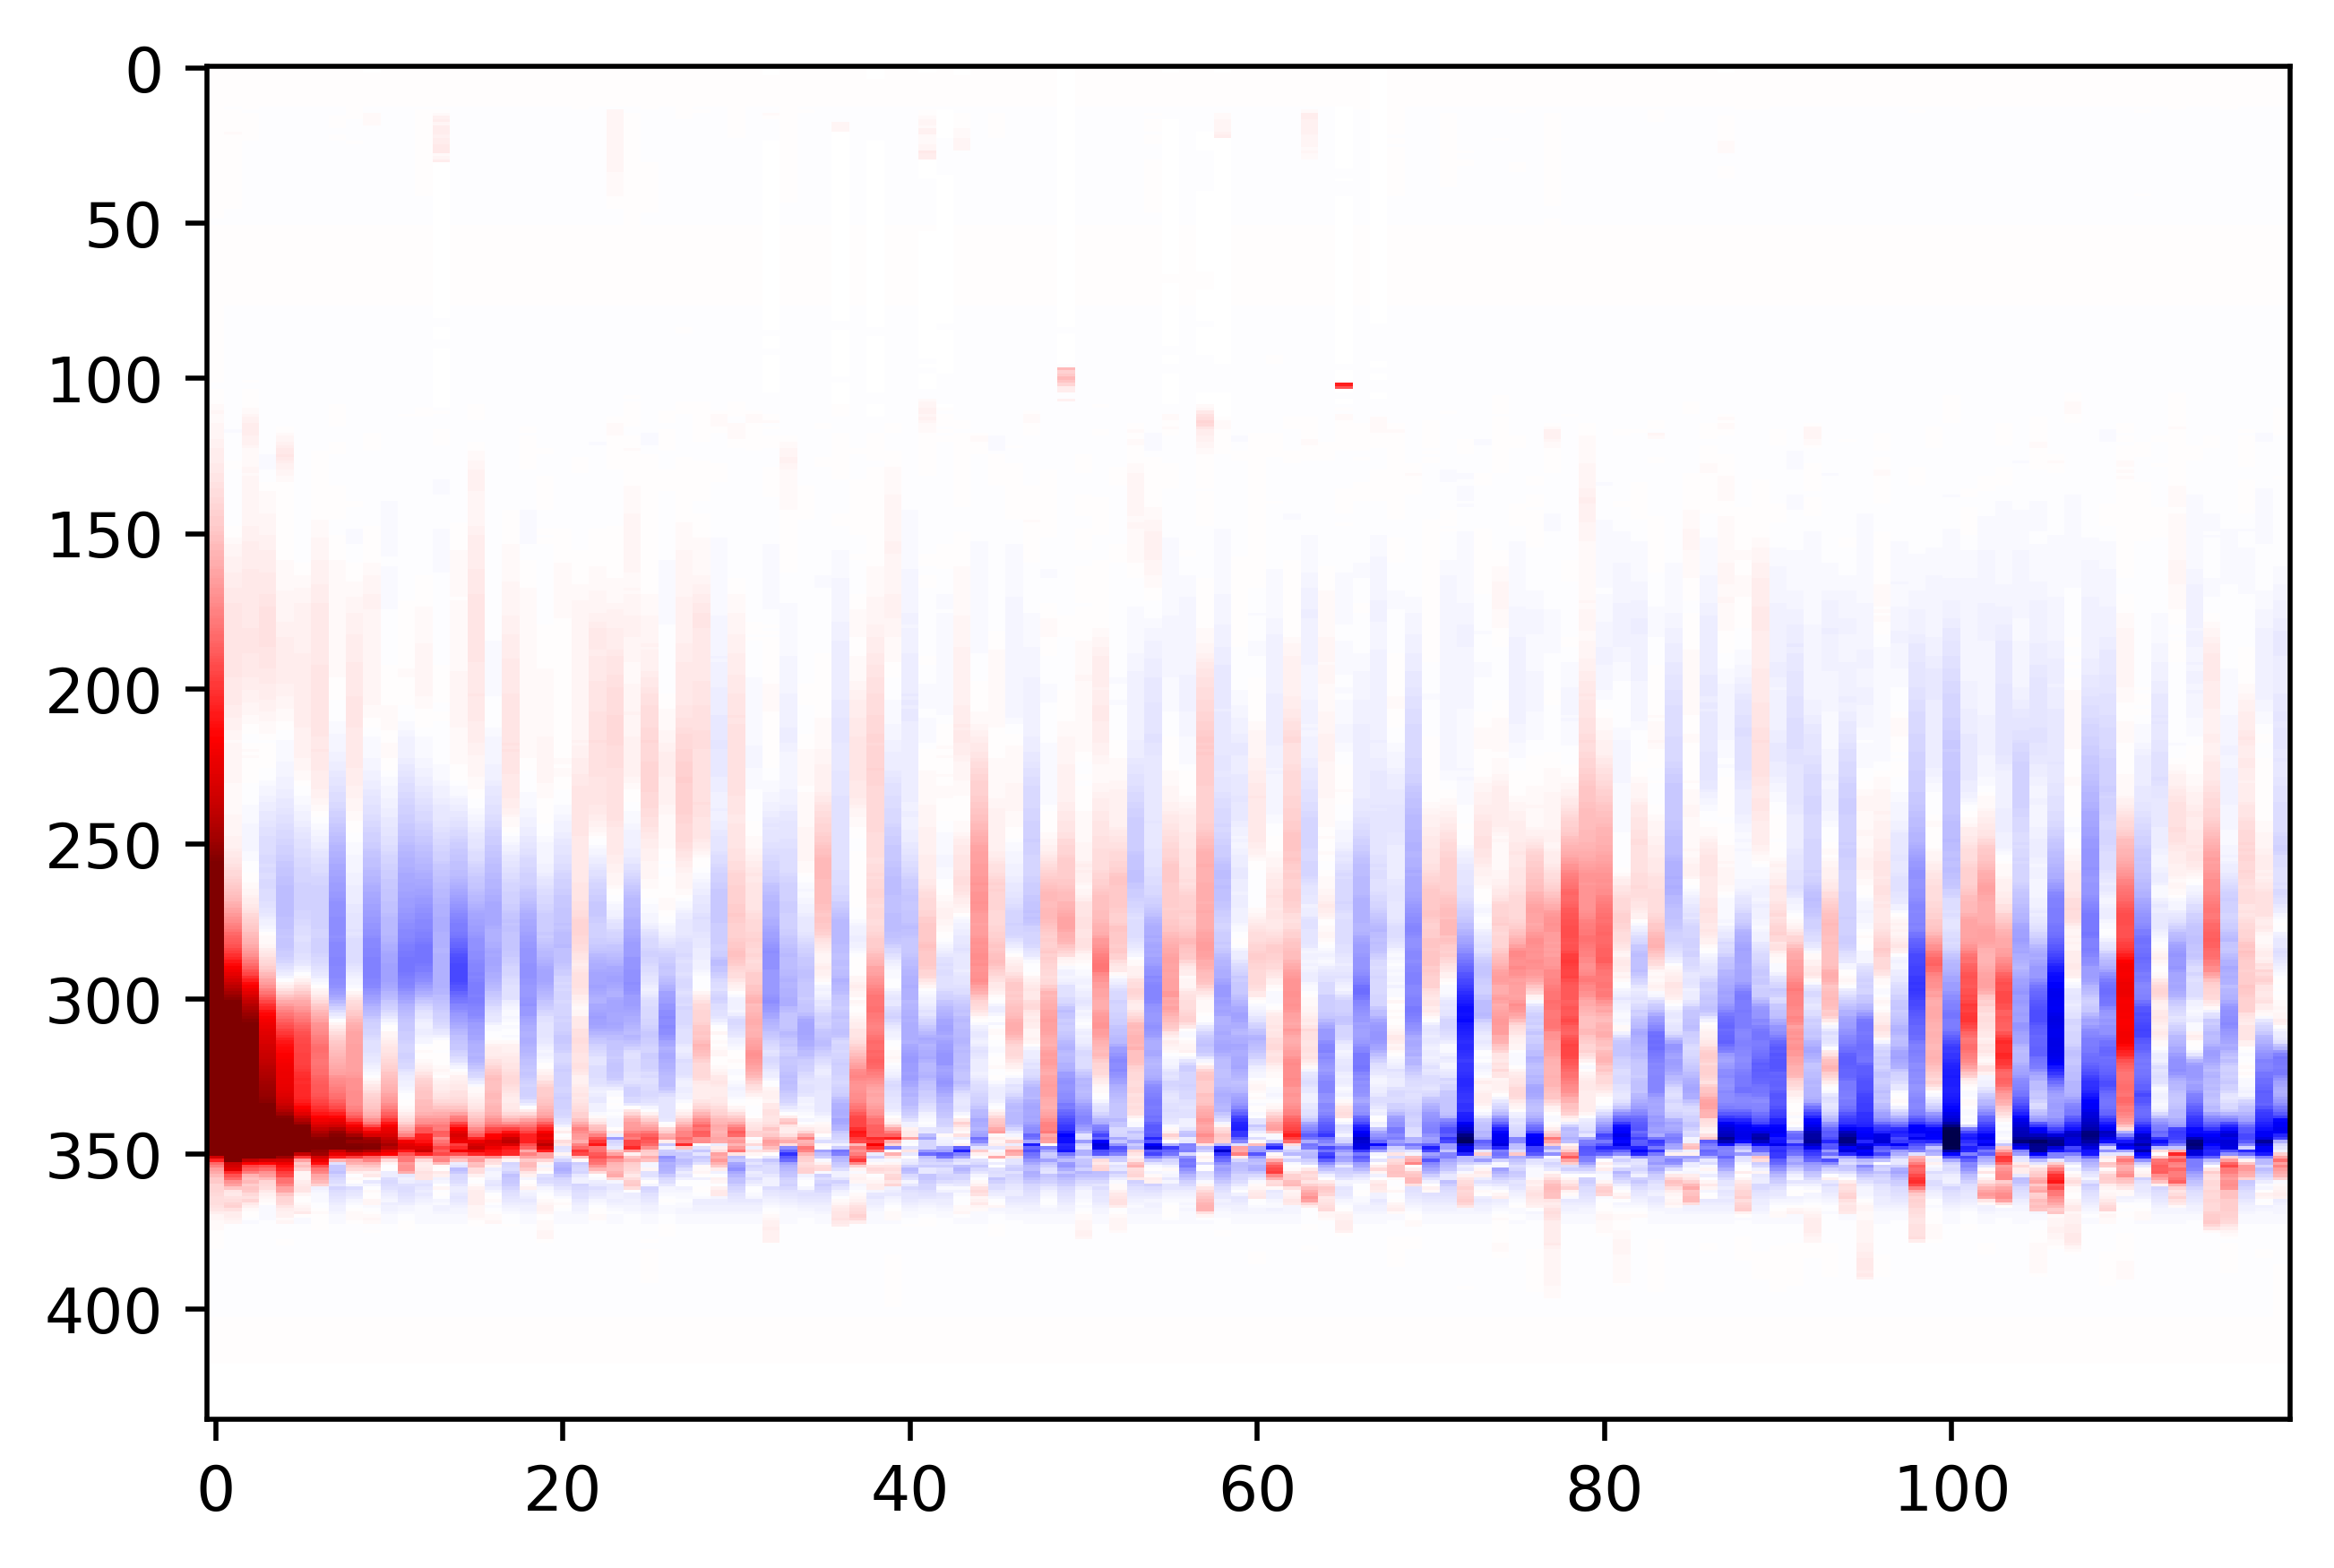

In [49]:
plt.figure(dpi=500)
plt.imshow(((year_iwc[2,0:120]/year_iwc[3,0:120]) - iwc_mean).T,aspect='auto',cmap='seismic',vmin=-.0001,vmax=0.0001)

#plt.figure(dpi=500)
#plt.imshow((year_iwc[2]/year_iwc[3]).T,aspect='auto')